# One-Zone Model Degeneracies

Looking for degeneracies between Ia DTD and other parameters in the one-zone model outputs.

Preamble

In [56]:
from pathlib import Path
import math as m
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import vice

# Evolution functions
from dtd import Bimodal, PowerLaw, BrokenPowerLaw
from dtd import Exponential as ExponentialDTD
from sfh import InsideOut, LateBurst, Constant, normalize
from sfh import Exponential as ExponentialSFH
from sfh import test_plot as plot_sfh

# VICE yields
from vice.yields.presets import JW20
vice.yields.ccsne.settings['fe'] = 0.0014

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Plot styles
COLORS = {
    'powerlaw': 'black',
    'powerlaw_broken': 'orange',
    'powerlaw_steep': 'purple',
    'exponential': 'blue',
    'exponential_long': 'green',
    'bimodal': 'red'
}
LINESTYLES = {
    'insideout': '-',
    'lateburst': '--',
    'exponential': ':',
    'constant': '-.',
    'efficiencywave': (0, (3, 1, 1, 1, 1, 1)), #dash-dot-dot,
    'conroy22': (0, (3, 1)), # densely dashed
}

# Simulation time
TMAX = 13.2 # Gyr
DT = 0.005 # Gyr
simtime = np.arange(0, TMAX+DT, DT) # Gyr

# Minimum Ia delay time
DELAY = 0.04 # Gyr

# Stellar mass of Milky Way (Licquia & Newman 2015, ApJ, 806, 96)
M_STAR_MW = 5.17e10

# Default one-zone model parameters
params = dict(
    elements=('fe', 'o', 'mg'),
    delay=DELAY,
    mode='sfr',
    dt=DT,
    eta=2.15,
)

## Star Formation Histories

Define star formation histories

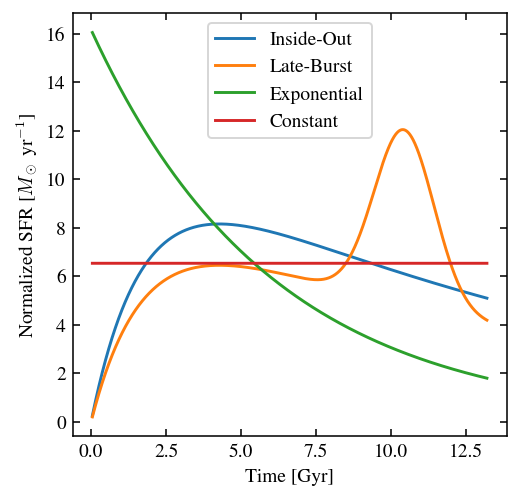

In [21]:
insideout = InsideOut()
lateburst = LateBurst()
exp_sfh = ExponentialSFH()
const_sfh = Constant()

plot_sfh()

## SN Ia delay time distributions

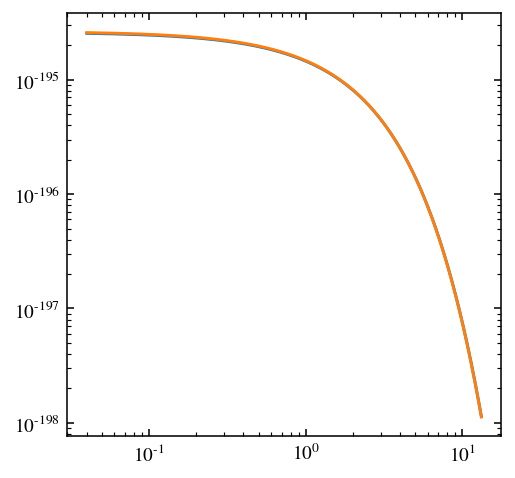

In [107]:
class SkewNormalDTD:
    def __init__(self, location=-1518, omega=51, shape=50):
        self.location = location
        self.omega = omega
        self.shape = shape
        self.norm = 1 / (omega * m.pi)
    
    def __call__(self, time):
        # upperbound = int(self.shape * ((time - self.location) / m.sqrt(self.width)))
        # lowerbound = -10
        # integral = sum([m.exp(-t**2/2) for t in range(lowerbound, upperbound)])
        return self.norm * m.exp(-(time - self.location)**2 / (2*self.omega**2)) #* integral

func = SkewNormalDTD()
time = [i*0.001 for i in range(40, 13201)]
plt.plot(time, [func(t) for t in time])
plt.plot(time, [1/1.7 * m.exp(-t/1.7) * 4.5e-195 for t in time])
plt.xscale('log')
plt.yscale('log')
plt.show()

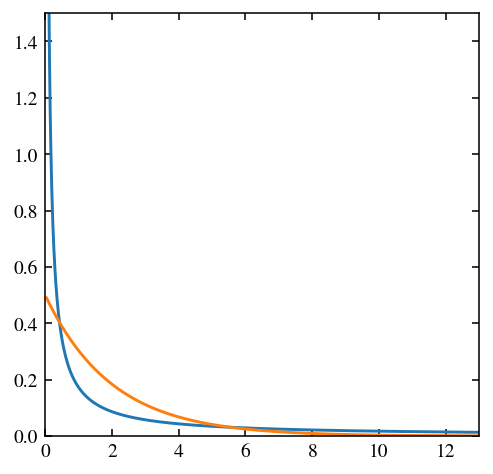

In [95]:
tarr = np.arange(0.04, 13, 0.01)
plt.plot(tarr, 1/(np.log(13) - np.log(0.04)) *tarr**-1)
plt.plot(tarr, 0.5*np.exp(-tarr/2))
plt.ylim((0, 1.5))
plt.xlim((0, 13))
plt.show()

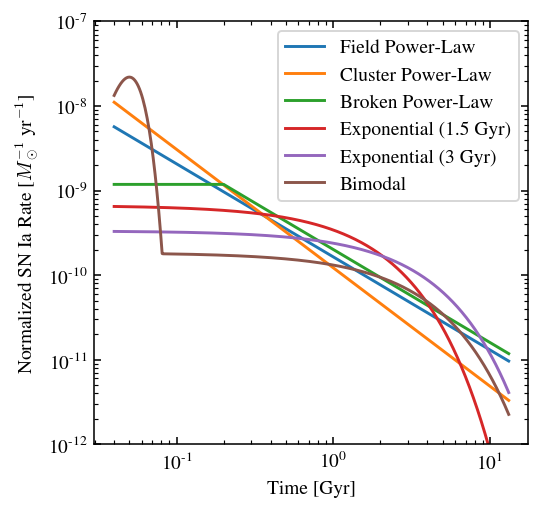

In [60]:
fig, ax = plt.subplots()
dtds = {
        'Field Power-Law': PowerLaw(),
        'Cluster Power-Law': PowerLaw(slope=-1.4),
        'Broken Power-Law': BrokenPowerLaw(),
        # 'Broken Power-Law': BrokenPowerLaw(slope1=-0.5, tsplit=1),
        'Exponential (1.5 Gyr)': ExponentialDTD(timescale=1.5),
        # 'Exponential (2 Gyr)': ExponentialDTD(timescale=2),
        'Exponential (3 Gyr)': ExponentialDTD(timescale=3),
        'Bimodal': Bimodal()
}
time = [0.001*i for i in range(40, 13201)]
for dist in list(dtds.keys()):
    func = dtds[dist]
    ax.plot(time, [func(t) for t in time], label=dist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-12, 1e-7))
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'Normalized SN Ia Rate [$M_\odot^{-1}$ yr$^{-1}$]')
ax.legend()
plt.show()

In [4]:
plaw_dtd = PowerLaw()
broken_dtd = BrokenPowerLaw()
plaw_dtd_steep = PowerLaw(slope=-1.4)
exp_dtd = ExponentialDTD()
exp_dtd_long = ExponentialDTD(timescale=3)
bi_dtd = Bimodal()

Run models

In [4]:
params['elements'] = ('fe', 'o', 'mg')
sz = vice.singlezone(name='outputs/constant/powerlaw', func=const_sfh, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/constant/powerlaw_broken', func=const_sfh, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/constant/exponential', func=const_sfh, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/constant/exponential_long', func=const_sfh, RIa=exp_dtd_long, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/constant/bimodal', func=const_sfh, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='outputs/insideout/powerlaw', func=insideout, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/insideout/powerlaw_broken', func=insideout, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/insideout/exponential', func=insideout, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/insideout/exponential_long', func=insideout, RIa=exp_dtd_long, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/insideout/bimodal', func=insideout, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='outputs/lateburst/powerlaw', func=lateburst, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/lateburst/powerlaw_broken', func=lateburst, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/lateburst/exponential', func=lateburst, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/lateburst/exponential_long', func=lateburst, RIa=exp_dtd_long, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/lateburst/bimodal', func=lateburst, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

sz = vice.singlezone(name='outputs/exponential/powerlaw', func=exp_sfh, RIa=plaw_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/exponential/powerlaw_broken', func=exp_sfh, RIa=broken_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/exponential/exponential', func=exp_sfh, RIa=exp_dtd, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/exponential/exponential_long', func=exp_sfh, RIa=exp_dtd_long, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/exponential/bimodal', func=exp_sfh, RIa=bi_dtd, **params)
sz.run(simtime, overwrite=True)

In [22]:
sz = vice.singlezone(name='outputs/constant/powerlaw_steep', func=const_sfh, RIa=plaw_dtd_steep, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/insideout/powerlaw_steep', func=insideout, RIa=plaw_dtd_steep, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/lateburst/powerlaw_steep', func=lateburst, RIa=plaw_dtd_steep, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/exponential/powerlaw_steep', func=exp_sfh, RIa=plaw_dtd_steep, **params)
sz.run(simtime, overwrite=True)

Plotting helper functions

In [12]:
def tri_plot(tlim=(-1, 14), felim=(-2, 0.5), olim=(-0.1, 0.45), alpha_tracer='O'):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # First panel: metallicity vs time
    ax = axs[0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Second panel: alpha vs time
    ax = axs[1]
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[' + alpha_tracer + '/Fe]')

    # Third panel: alpha vs fe
    ax = axs[2]
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[' + alpha_tracer + '/Fe]')
    
    return fig, axs


def quad_plot(tlim=(-1, 14), felim=(-2, 0.5), ofelim=(-0.3, 0.5), ohlim=(-2, 0.5)):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    
    # First panel: [Fe/O] vs [O/H]
    ax = axs[0,0]
    ax.set_xlim(ohlim)
    ax.set_ylim((-ofelim[1], -ofelim[0]))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[O/H]')
    ax.set_ylabel('[Fe/O]')
    
    # Second panel: [O/Fe] vs [Fe/H]
    ax = axs[0,1]
    ax.set_xlim(felim)
    ax.set_ylim(ofelim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')

    # Third panel: [Fe/H] vs time
    ax = axs[1,0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Fourth panel: [O/Fe] vs time
    ax = axs[1,1]
    ax.set_xlim(tlim)
    ax.set_ylim(ofelim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[O/Fe]')
    
    return fig, axs

## Infall & Efficiency Experiments

In [7]:
hist = vice.history('outputs/lateburst/powerlaw')
ifr_integral = 0
for i in range(len(simtime)-1):
    ifr_integral += hist['ifr'][i+1] * DT * 1e9
print(ifr_integral)
sfr_integral = 0
for i in range(len(simtime)-1):
    sfr_integral += hist['sfr'][i+1] * DT * 1e9
print(sfr_integral)
ifr_scale = ifr_integral / sfr_integral
print(ifr_scale)

245274853300.0
86183385775.0
2.845964463966895


In [23]:
# Efficiency-driven starburst
# Exponentially declining IFR with a Gaussian burst in tau_star

def tau_star_burst(time, Mg):
    plateau = 5
    trough = 0.5
    sigma = 1.5
    center = 11.5
    gauss = (plateau - trough) * m.exp(-(time - center)**2/(2*sigma**2))
    return plateau - gauss

def exp_ifr(time):
    tau_ifr = 15
    decline = m.exp(-time/tau_ifr)
    rise = 0.67*m.exp(-time/2)
    return 450 / tau_ifr * (1-rise) * decline

params['mode'] = 'ifr'
params['Mg0'] = 0
sz = vice.singlezone(name='outputs/efficiencyburst/powerlaw', func=exp_ifr, RIa=plaw_dtd, tau_star=tau_star_burst, **params)
sz.run(simtime, overwrite=True)

# Efficiency-driven starburst
# Exponentially declining IFR with a logistic drop in tau_star

def tau_star_drop(time, Mg):
    plateau = 5
    trough = 0.5
    k = 2
    center = 10
    return plateau - (plateau - trough) / (1 + m.exp(-k * (time - center)))

sz = vice.singlezone(name='outputs/efficiencydrop/powerlaw', func=exp_ifr, RIa=plaw_dtd, tau_star=tau_star_drop, **params)
sz.run(simtime, overwrite=True)

# Efficiency-driven starburst
# Exponentially declining IFR with a logistic drop + Gaussian bursts in tau-star

def tau_star_wave(time, Mg):
    plateau = 2
    trough = 0.5
    peak = 5
    center1 = 8
    sigma1 = 3
    gauss1 = m.exp(-(time-center1)**2/(2*sigma1**2))
    center2 = 11
    sigma2 = 1
    gauss2 = m.exp(-(time-center2)**2/(2*sigma2**2))
    k = 2
    center = 10
    logistic = 1 / (1 + m.exp(-k * (time - center)))
    return plateau + (peak - plateau) * gauss1 * (1-logistic) - (plateau - trough) * gauss2 * logistic

sz = vice.singlezone(name='outputs/efficiencywave/powerlaw', func=exp_ifr, RIa=plaw_dtd, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)

# Infall-driven starburst
# Exponentially declining IFR with late Gaussian burst in IFR and constant tau_star

def tau_star_const(time, Mg):
    return 2

def lateburst_ifr(time):
    tau_ifr = 15
    decline = m.exp(-time/tau_ifr)
    rise = 0.67*m.exp(-time/2)
    sigma = 1
    center = 10
    burst = 2 * m.exp(-(time - center)**2/(2*sigma**2))
    return 375 / tau_ifr * (1-rise) * decline * (1 + burst)

sz = vice.singlezone(name='outputs/infallburst/powerlaw', func=lateburst_ifr, RIa=plaw_dtd, tau_star=tau_star_const, **params)
sz.run(simtime, overwrite=True)

There are two paths I took to mimic the late-burst star formation history. The first was an infall rate with basically the same functional form. Unsurprisingly, this produced a model with parameters almost identical to the late-burst SFH model, including the [Fe/H] depletion at the time of the burst. The second path was to implement an exponential infall rate (similar to the inside-out SFH model) and try to control the burst with $\tau_*$ as a function of time. The burst is mainly driven by a steep decrease in $\tau_*$ which I model as either a Gaussian or logistic function. The best fit I got is actually a combination of a positive Gaussian to bring $\tau_*$ up from its initial value of 2 Gyr to ~5 Gyr, then a logistic drop at 10 Gyr, and then a Gaussian to bring $\tau_*$ back to the fiducial value of 2 Gyr. However, I did also implement a couple of other forms, such as a single Gaussian or a single logistic. These latter models don't fit the late-burst model super well, though. It's hard to get the right SFR burst magnitude without a really big change in $\tau_*$.

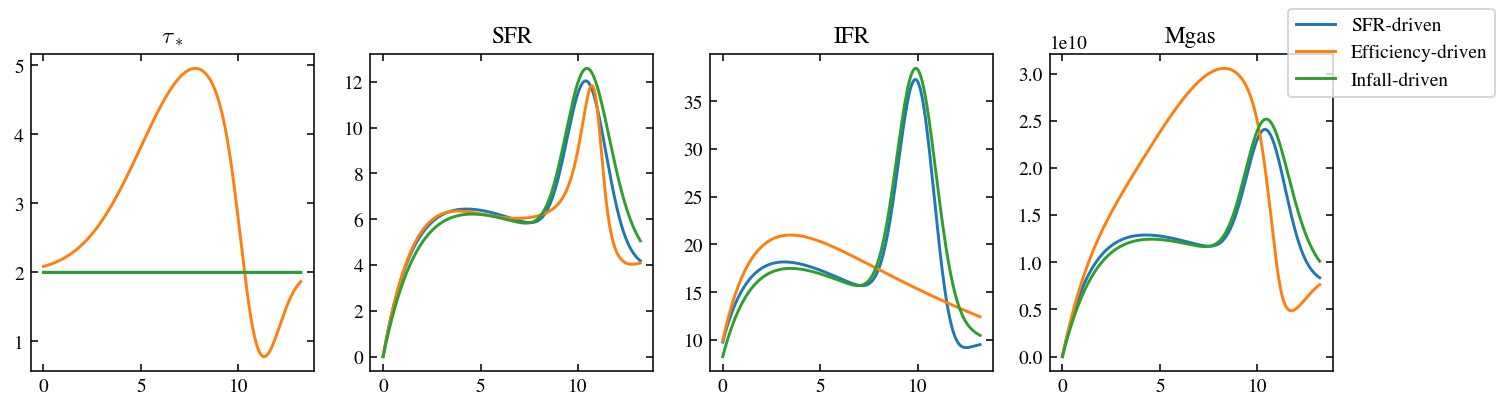

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
runs = ['lateburst/powerlaw', 'efficiencywave/powerlaw', 'infallburst/powerlaw']
labels = ['SFR-driven', 'Efficiency-driven', 'Infall-driven']
for run, label in zip(runs, labels):
    hist = vice.history('outputs/' + run)
    axs[0].plot(simtime[1:], [hist['mgas'][i+1] / hist['sfr'][i+1] * 1e-9 for i in range(len(simtime)-1)])
    axs[1].plot(simtime, hist['sfr'], label=label)
    axs[2].plot(simtime, hist['ifr'])
    axs[3].plot(simtime, hist['mgas'])
axs[0].set_title(r'$\tau_*$')
axs[1].set_title('SFR')
axs[2].set_title('IFR')
axs[3].set_title('Mgas')
fig.legend()
plt.show()

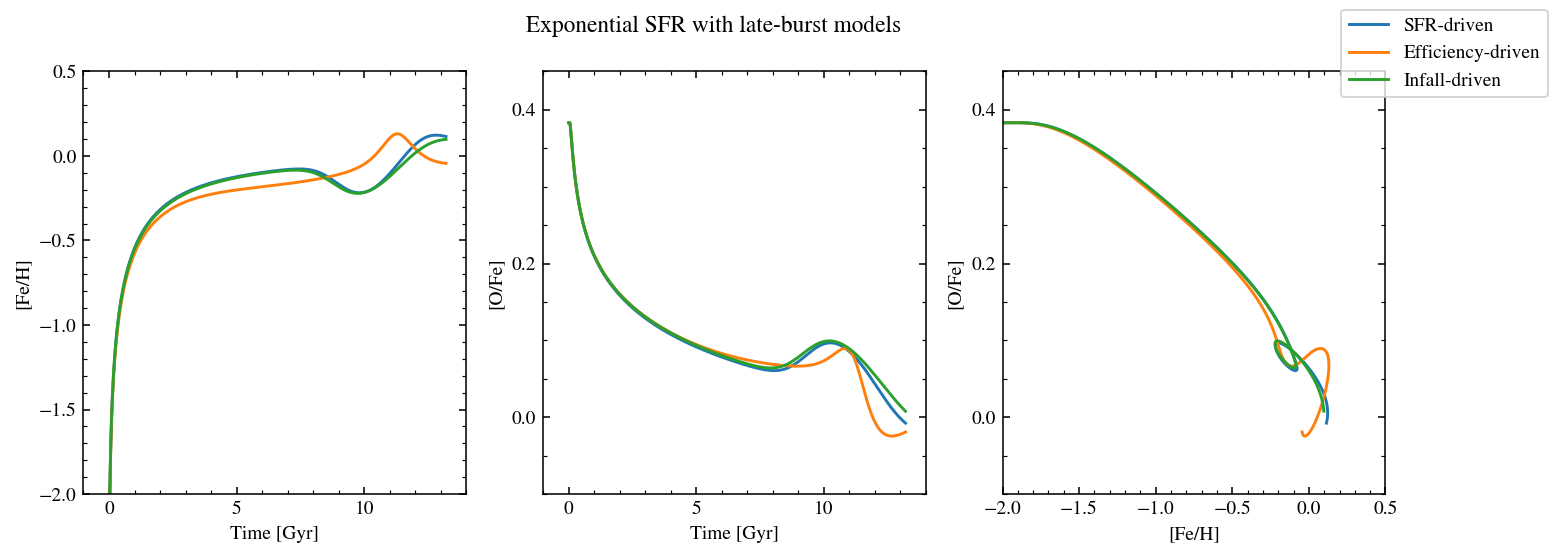

In [10]:
fig, axs = tri_plot(olim=(-0.1, 0.45))
runs = ['lateburst/powerlaw', 'efficiencywave/powerlaw', 'infallburst/powerlaw']
labels = ['SFR-driven', 'Efficiency-driven', 'Infall-driven']
for run, label in zip(runs, labels):
    history = vice.history('outputs/' + run)
    axs[0].plot(history['time'], history['[fe/h]'], label=label)
    axs[1].plot(history['time'], history['[o/fe]'])
    axs[2].plot(history['[fe/h]'], history['[o/fe]'])
fig.legend()
fig.suptitle('Exponential SFR with late-burst models')
plt.show()

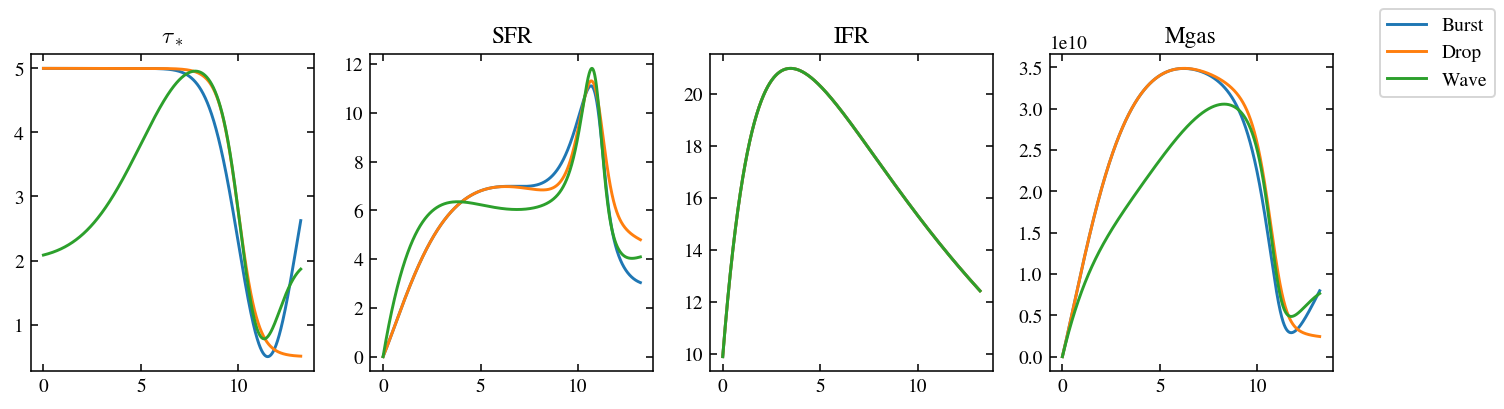

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
runs = ['efficiencyburst/powerlaw', 'efficiencydrop/powerlaw', 'efficiencywave/powerlaw']
labels = ['Burst', 'Drop', 'Wave']
for run, label in zip(runs, labels):
    hist = vice.history('outputs/' + run)
    axs[0].plot(simtime[1:], [hist['mgas'][i+1] / hist['sfr'][i+1] * 1e-9 for i in range(len(simtime)-1)])
    axs[1].plot(simtime, hist['sfr'], label=label)
    axs[2].plot(simtime, hist['ifr'])
    axs[3].plot(simtime, hist['mgas'])
axs[0].set_title(r'$\tau_*$')
axs[1].set_title('SFR')
axs[2].set_title('IFR')
axs[3].set_title('Mgas')
fig.legend()
plt.show()

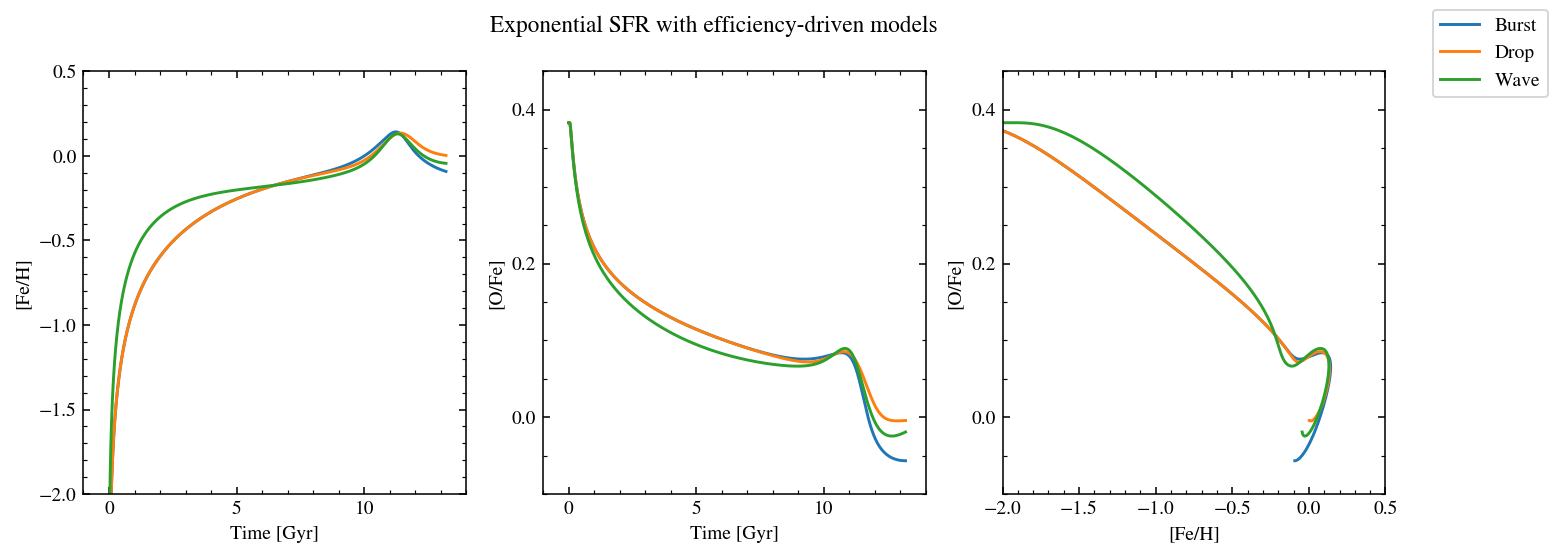

In [12]:
fig, axs = tri_plot(olim=(-0.1, 0.45))
runs = ['efficiencyburst/powerlaw', 'efficiencydrop/powerlaw', 'efficiencywave/powerlaw']
labels = ['Burst', 'Drop', 'Wave']
for run, label in zip(runs, labels):
    history = vice.history('outputs/' + run)
    axs[0].plot(history['time'], history['[fe/h]'], label=label)
    axs[1].plot(history['time'], history['[o/fe]'])
    axs[2].plot(history['[fe/h]'], history['[o/fe]'])
fig.legend()
fig.suptitle('Exponential SFR with efficiency-driven models')
plt.show()

In [24]:
params['mode'] = 'ifr'
sz = vice.singlezone(name='outputs/efficiencywave/powerlaw_broken', func=exp_ifr, RIa=broken_dtd, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/efficiencywave/powerlaw_steep', func=exp_ifr, RIa=plaw_dtd_steep, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/efficiencywave/exponential', func=exp_ifr, RIa=exp_dtd, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/efficiencywave/exponential_long', func=exp_ifr, RIa=exp_dtd_long, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/efficiencywave/bimodal', func=exp_ifr, RIa=bi_dtd, tau_star=tau_star_wave, **params)
sz.run(simtime, overwrite=True)

### Conroy+ 2022

In [41]:
vice.yields.ccsne.settings['fe'] = 0.0012
vice.yields.ccsne.settings['mg'] = 0.0026
vice.yields.sneia.settings['fe'] = 0.003

def tau_star(time):
    if time < 2.5:
        return 50.
    elif time >= 2.5 and time <= 3.7:
        return 50. / ((1 + 3*(time-2.5))**2)
    else:
        return 2.36
    
def ifr_constant(time):
    return 5

conroy22_params = {
    'func': ifr_constant,
    'mode': 'ifr',
    'elements': ('fe', 'mg'),
    'eta': 2.,
    'Mg0': 0.,
    'tau_star': tau_star,
    'dt': DT,
    'delay': 0.04,
}

sz = vice.singlezone(name='outputs/conroy22/powerlaw', RIa=plaw_dtd, **conroy22_params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/conroy22/powerlaw_steep', RIa=plaw_dtd_steep, **conroy22_params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/conroy22/powerlaw_broken', RIa=broken_dtd, **conroy22_params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/conroy22/exponential', RIa=exp_dtd, **conroy22_params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/conroy22/exponential_long', RIa=exp_dtd_long, **conroy22_params)
sz.run(simtime, overwrite=True)
sz = vice.singlezone(name='outputs/conroy22/bimodal', RIa=bi_dtd, **conroy22_params)
sz.run(simtime, overwrite=True)

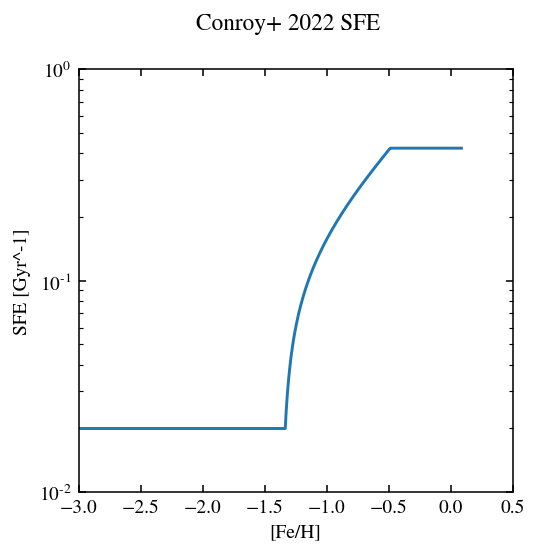

In [39]:
hist = vice.history('outputs/conroy22/powerlaw')
fig, ax = plt.subplots()
ax.plot(hist['[fe/h]'], np.array(hist['sfr']) / np.array(hist['mgas']) * 1e9)
ax.set_yscale('log')
ax.set_ylim((0.01, 1))
ax.set_xlim((-3, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('SFE [Gyr^-1]')
fig.suptitle('Conroy+ 2022 SFE')
plt.show()

## Abundance Tracks

In [14]:
def get_ofe_drop(name, delta_ofe=0.1):
    """Returns the metallicity at which [O/Fe] drops 0.1 dex below the plateau."""
    
    history = vice.history(name)
    feh = history['[fe/h]']
    ofe = history['[o/fe]']
    plateau = ofe[1]
    drop = [f for i, f in enumerate(feh) if ofe[i] < plateau - delta_ofe][0]
    return drop

get_ofe_drop('outputs/insideout/powerlaw')

-0.9447835472532857

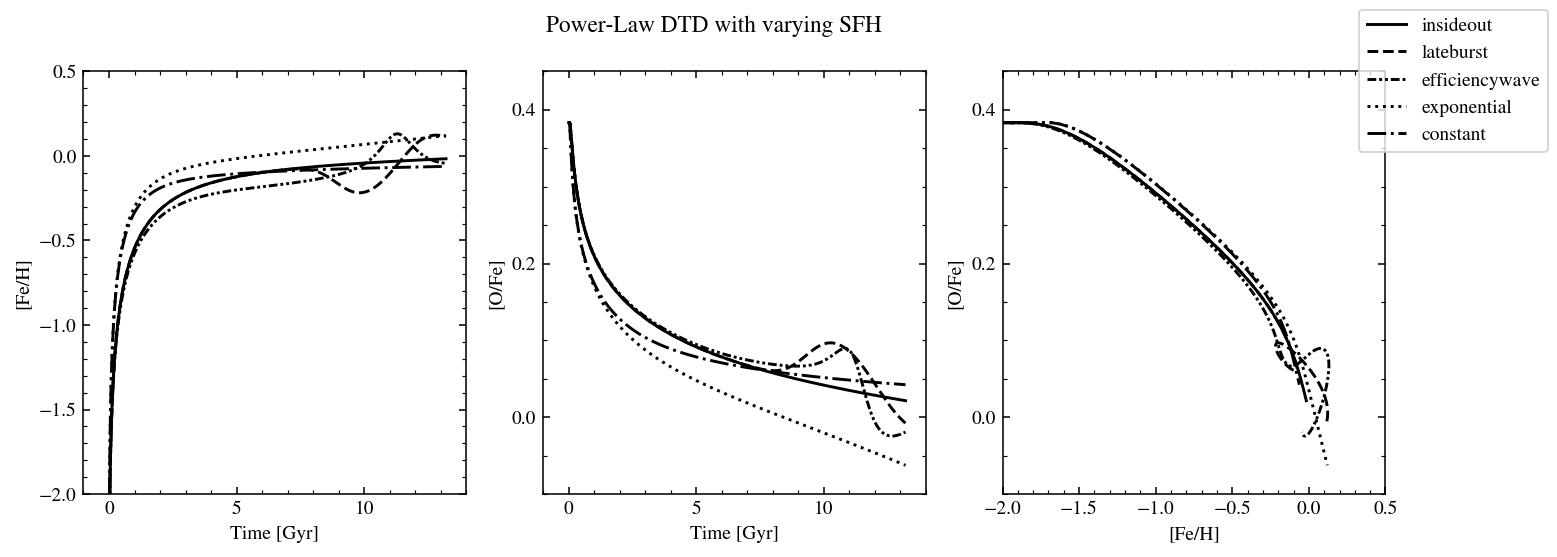

In [59]:
# Different SFHs with same DTD
fig, axs = tri_plot(olim=(-0.1, 0.45))
sfhs = ['insideout', 'lateburst', 'efficiencywave', 'exponential', 'constant']
dtd = 'powerlaw'
c = 'k'
for sfh in sfhs:
    ls = LINESTYLES[sfh]
    history = vice.history(os.path.join('outputs', sfh, dtd))
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=sfh)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Power-Law DTD with varying SFH')
plt.show()

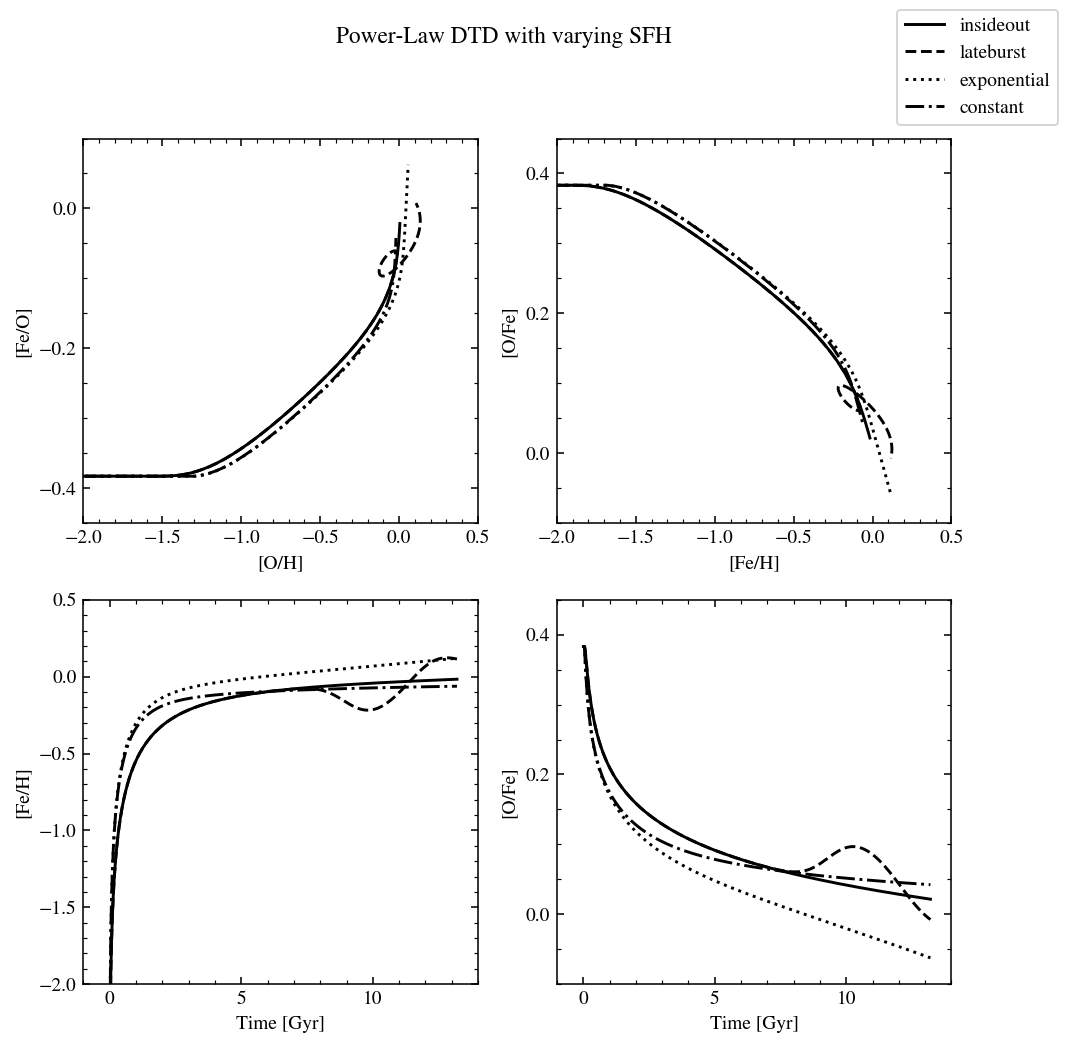

In [16]:
# Different SFHs with same DTD
fig, axs = quad_plot(ofelim=(-0.1, 0.45))
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
styles = ['-', '--', ':', '-.']
dtd = 'powerlaw'
c = 'k'
for sfh, ls in zip(sfhs, styles):
    history = vice.history(os.path.join('outputs', sfh, dtd))
    axs[0,0].plot(history['[o/h]'], history['[fe/o]'], color=c, linestyle=ls, label=sfh)
    axs[0,1].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
    axs[1,0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls)
    axs[1,1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Power-Law DTD with varying SFH')
plt.show()

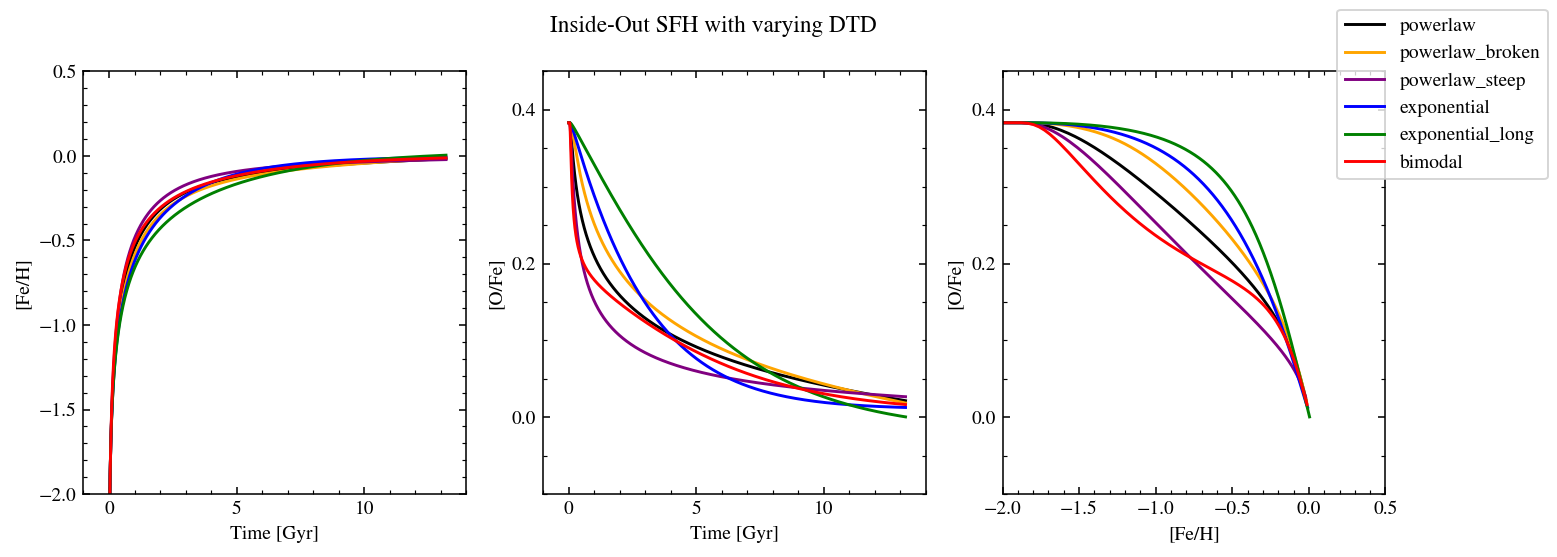

In [25]:
# Different DTDs with same SFH
fig, axs = tri_plot()
dtds = ['powerlaw', 'powerlaw_broken', 'powerlaw_steep', 'exponential', 'exponential_long', 'bimodal']
sfh = 'insideout'
ls = '-'
for dtd in dtds:
    history = vice.history(str(os.path.join('outputs', sfh, dtd)))
    c = COLORS[dtd]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=dtd)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

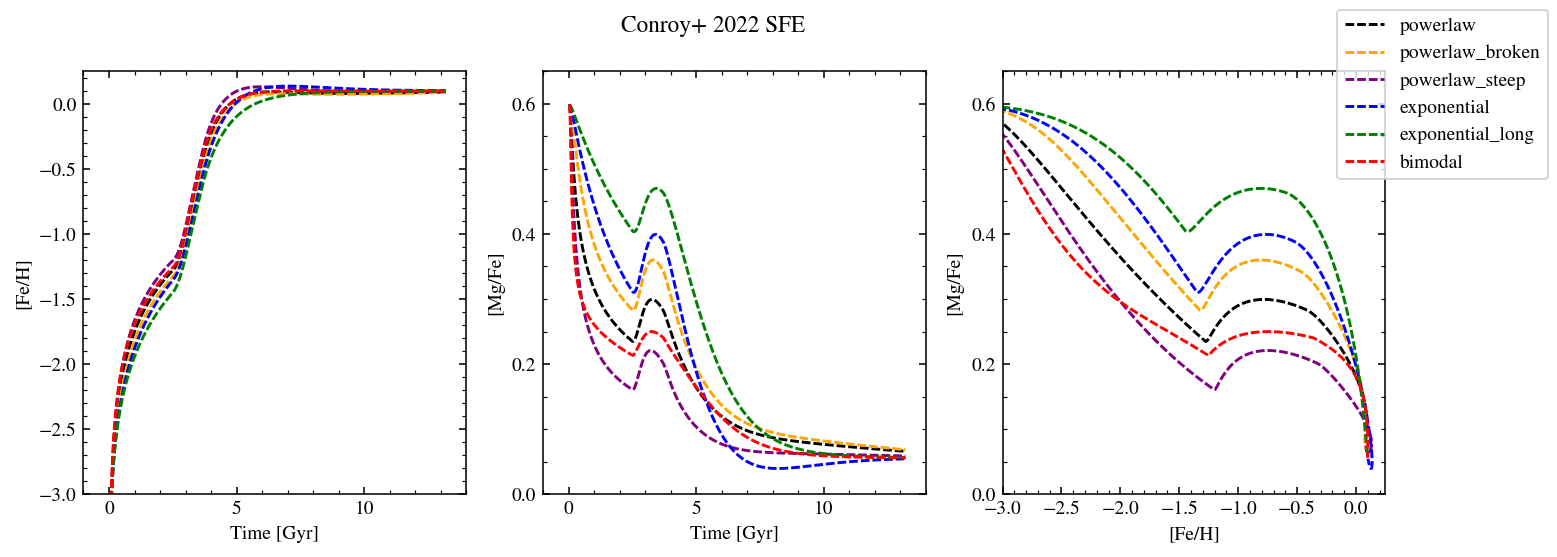

In [57]:
fig, axs = tri_plot(alpha_tracer='Mg', olim=(0, 0.65), felim=(-3, 0.25))
dtds = ['powerlaw', 'powerlaw_broken', 'powerlaw_steep', 'exponential', 'exponential_long', 'bimodal']
sfh = 'conroy22'
ls = LINESTYLES[sfh]
for dtd in dtds:
    history = vice.history(str(os.path.join('outputs', sfh, dtd)))
    c = COLORS[dtd]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=dtd)
    axs[1].plot(history['time'], history['[mg/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[mg/fe]'], color=c, linestyle=ls)
fig.suptitle('Conroy+ 2022 SFE')
fig.legend()
plt.show()

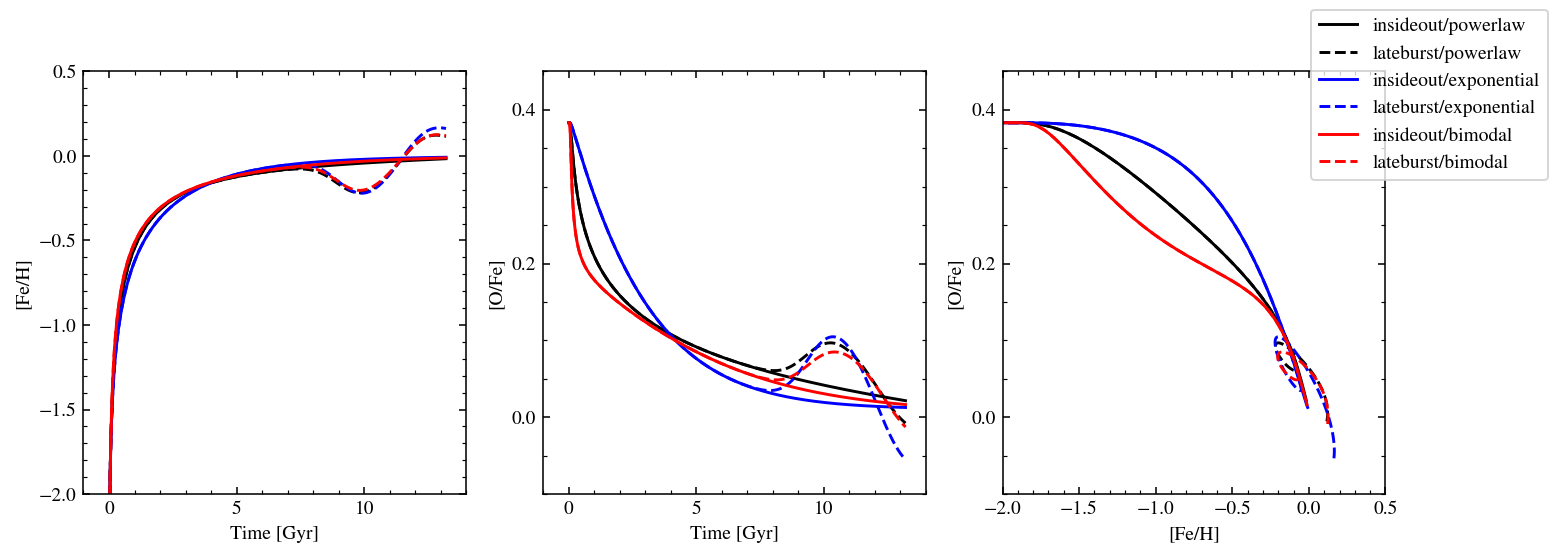

In [40]:
# Power-law vs exponential
fig, axs = tri_plot()
runs = ['insideout/powerlaw', 'lateburst/powerlaw', 'insideout/exponential', 'lateburst/exponential', 'insideout/bimodal', 'lateburst/bimodal']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
# fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

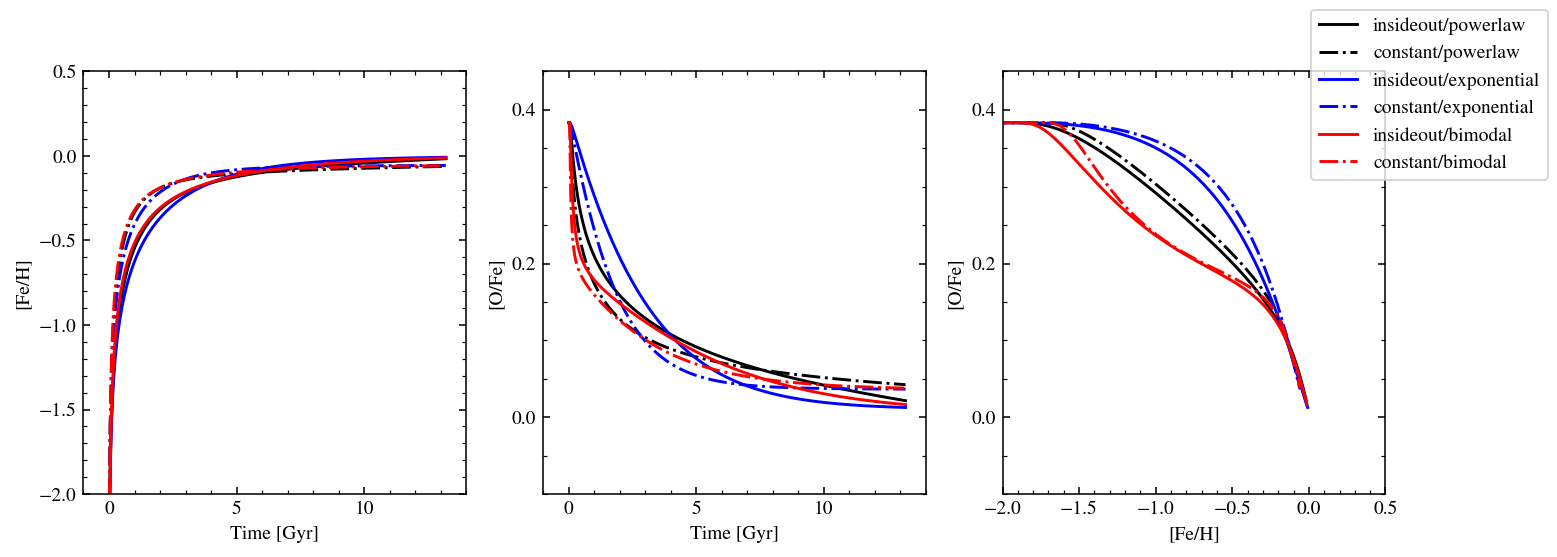

In [52]:
# Power-law vs exponential
fig, axs = tri_plot()
runs = ['insideout/powerlaw', 'constant/powerlaw', 'insideout/exponential', 'constant/exponential', 'insideout/bimodal', 'constant/bimodal']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
# fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

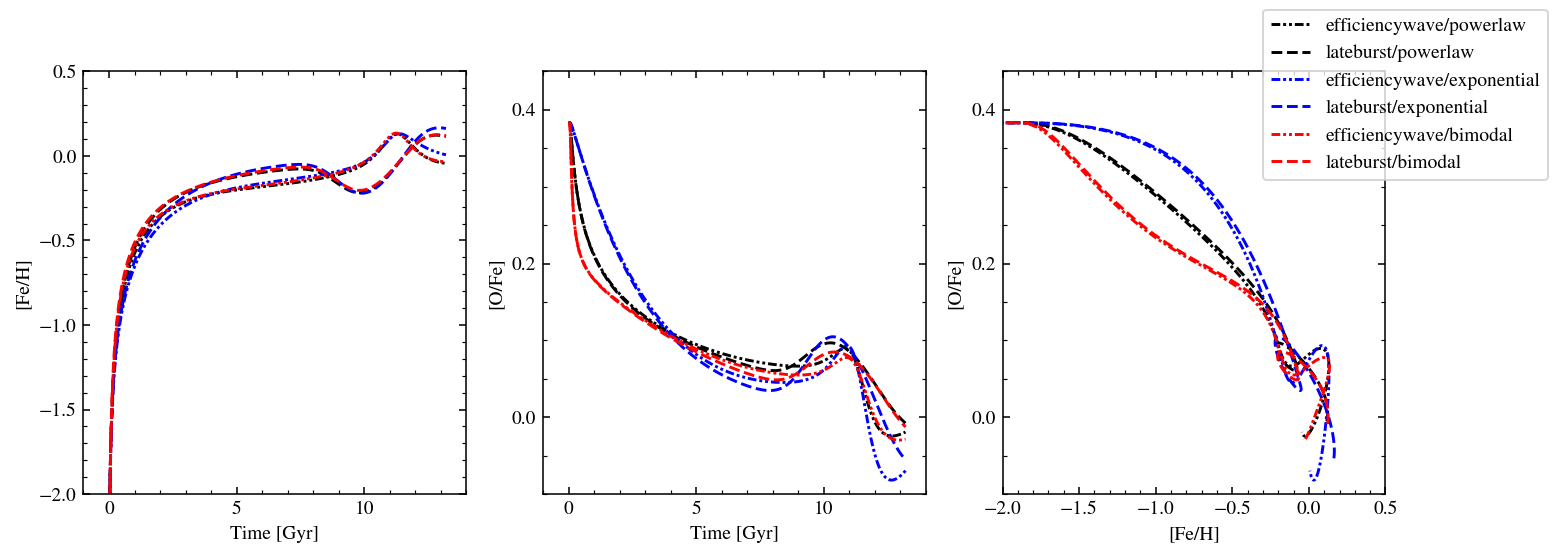

In [41]:
# Power-law vs exponential
fig, axs = tri_plot()
runs = ['efficiencywave/powerlaw', 'lateburst/powerlaw', 'efficiencywave/exponential', 'lateburst/exponential', 'efficiencywave/bimodal', 'lateburst/bimodal']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
# fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

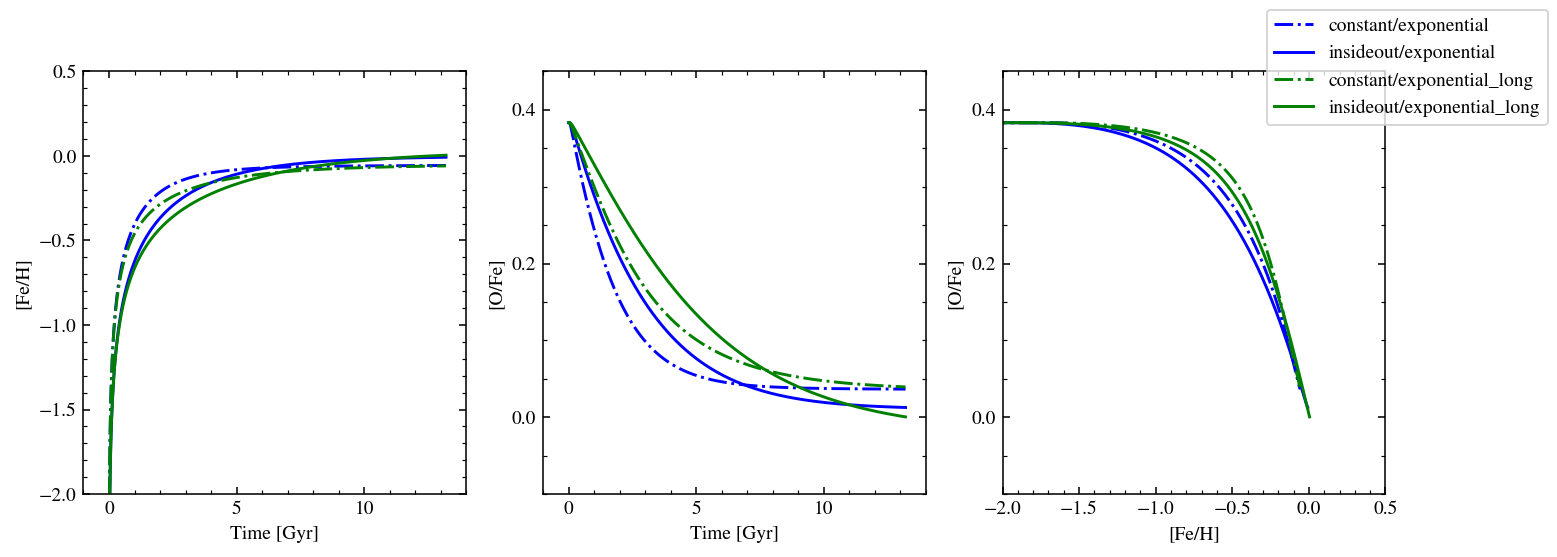

In [6]:
# Power-law vs exponential
fig, axs = tri_plot()
runs = ['constant/exponential', 'insideout/exponential', 'constant/exponential_long', 'insideout/exponential_long']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
# fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

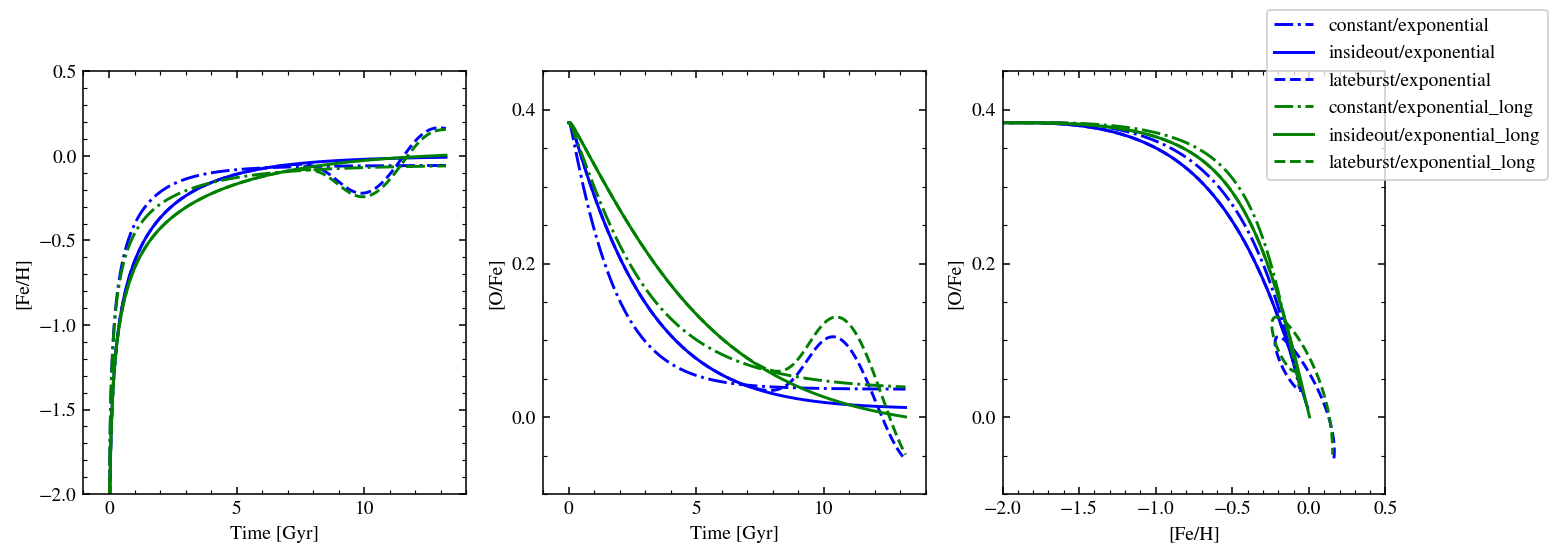

In [8]:
# Power-law vs exponential
fig, axs = tri_plot()
runs = ['constant/exponential', 'insideout/exponential', 'lateburst/exponential', 'constant/exponential_long', 'insideout/exponential_long', 'lateburst/exponential_long']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
# fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

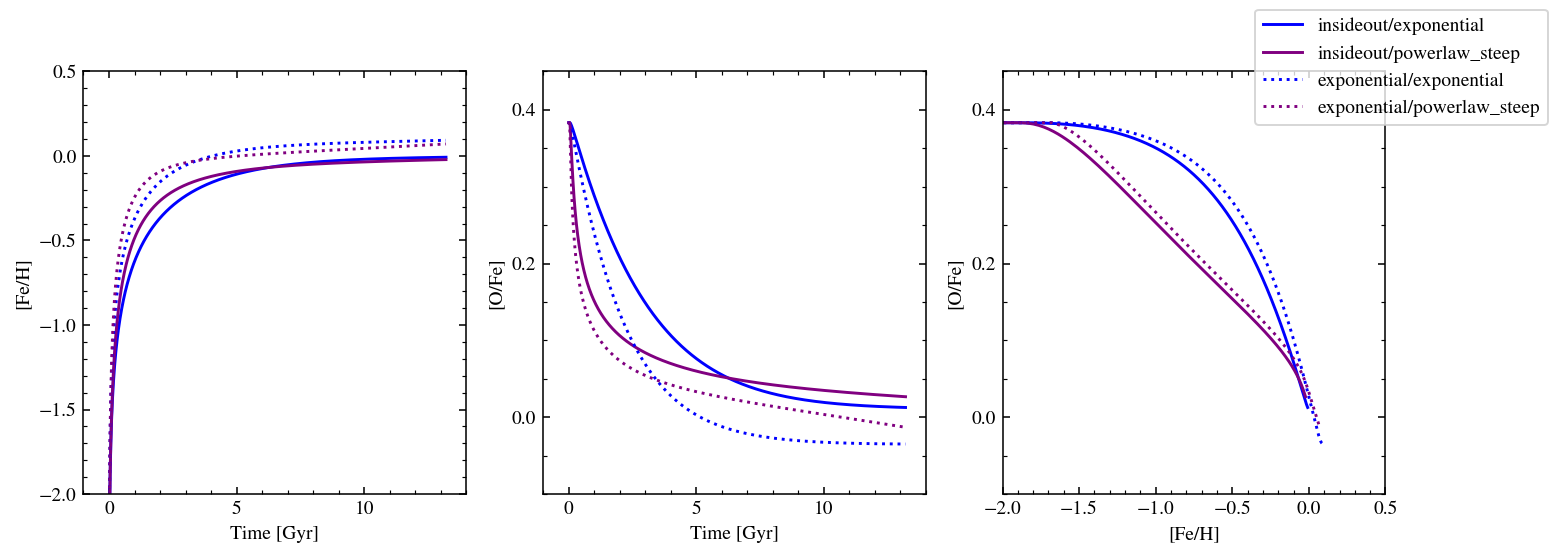

In [46]:
fig, axs = tri_plot()
runs = ['insideout/exponential', 'insideout/powerlaw_steep', 'exponential/exponential', 'exponential/powerlaw_steep']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
plt.show()

Inside-out vs constant SFH and exponential vs broken power-law are all very similar in [Fe/H] vs [O/Fe]. I'm not surprised that exponential and broken power-law are similar as those DTD curves look very similar. Also, I guess inside-out and constant SFHs are fairly similar to one another excluding the first couple Gyr. They have somewhat different tracks in [O/Fe] vs age, but age space will be the hardest to distinguish in observations. Once again, it will be impossible to distinguish DTDs in [Fe/H] vs age space because the changes due to SFH are so much bigger.

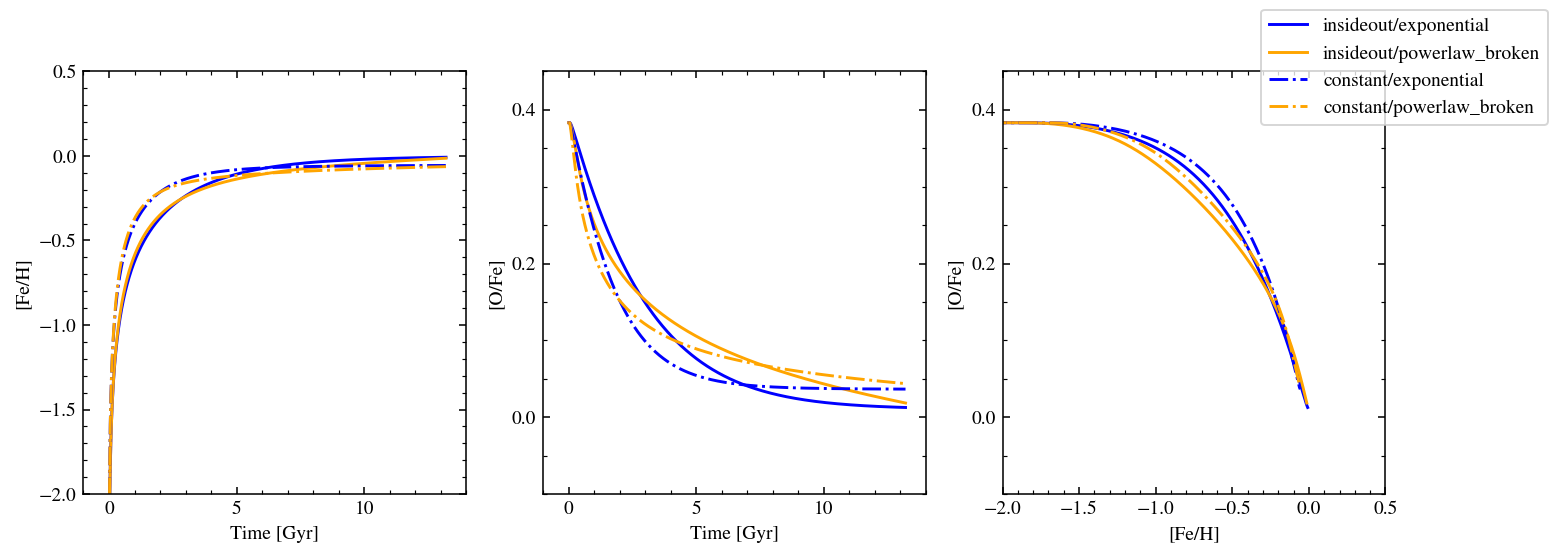

In [58]:
fig, axs = tri_plot()
runs = ['insideout/exponential', 'insideout/powerlaw_broken', 'constant/exponential', 'constant/powerlaw_broken']
for run in runs:
    history = vice.history(str(os.path.join('outputs', run)))
    ls = LINESTYLES[run.split('/')[0]]
    c = COLORS[run.split('/')[1]]
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=run)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
plt.show()

## MDFs

In [50]:
def tri_mdf(felim1=(-2.5, 0.5), felim2=(-1, 0.25), ylim2=(1e-2, 20), olim=(-0.2, 0.5), logy=True, alpha_tracer='O'):
    """Format triple-panel plot of metallicity and oxygen distribution functions."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    # First panel: [Fe/H] distribution function
    ax = axs[0]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim1)
    ax.set_ylabel('dN/d[Fe/H]')
    ax.set_yscale('log')
    
    # Second panel: zoom in near peak of first panel MDF
    ax = axs[1]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim2)
    if logy:
        ax.set_yscale('log')
    ax.set_ylim(ylim2)
    ax.set_ylabel('dN/d[Fe/H]')
    
    # Third panel: [O/Fe] distribution function
    ax = axs[2]
    ax.set_xlabel('[%s/Fe]' % alpha_tracer)
    ax.set_xlim(olim)
    ax.set_ylabel('dN/d[%s/Fe]' % alpha_tracer)
    if logy:
        ax.set_yscale('log')

    return fig, axs

def plot_mdf(runs, title='', legend_labels=[], alpha_tracer='O', **kwargs):
    """Generate complete plot of MDF and ODF for given one-zone runs."""
    
    fig, axs = tri_mdf(alpha_tracer=alpha_tracer, **kwargs)
    
    for run in runs:
        mdf = vice.mdf(os.path.join('outputs', run))
        bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
        sfh = run.split(os.sep)[0]
        dtd = run.split(os.sep)[1]
        c = COLORS[dtd]
        ls = LINESTYLES[sfh]
        axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
        axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
        axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[%s/fe]' % alpha_tracer.lower()], histtype='step', color=c, linestyle=ls)
    
    handles, labels = axs[0].get_legend_handles_labels()
    if len(legend_labels) == len(labels):
        labels = legend_labels
    fig.legend(handles, labels)
    
    fig.suptitle(title)
    plt.show()

Changes to the SFH at early times have the greatest effect on the high-alpha end of the ADF and the low-metallicity end of the MDF. Exponential, Constant, and Inside-Out are all quite different at early times, while Inside-Out and Late-Burst are almost identical then. Changes to the SFH at late times affect the peak of the MDF (near solar metallicity), and to a lesser extent, the low end of the ADF.

Same as above but swapping out the declining exponential SFH (somewhat unrealistic) for the SFE-driven burst ('efficiencywave'). The SFE-driven burst sees a shallower slope to the high-metallicity end of the MDF and not a "hook" shape seen in the SFR-driven burst. My guess is that the SFR-driven burst leads to metal depletion which lowers the MDF near solar, while the SFE-driven burst avoids the metal depletion issue.

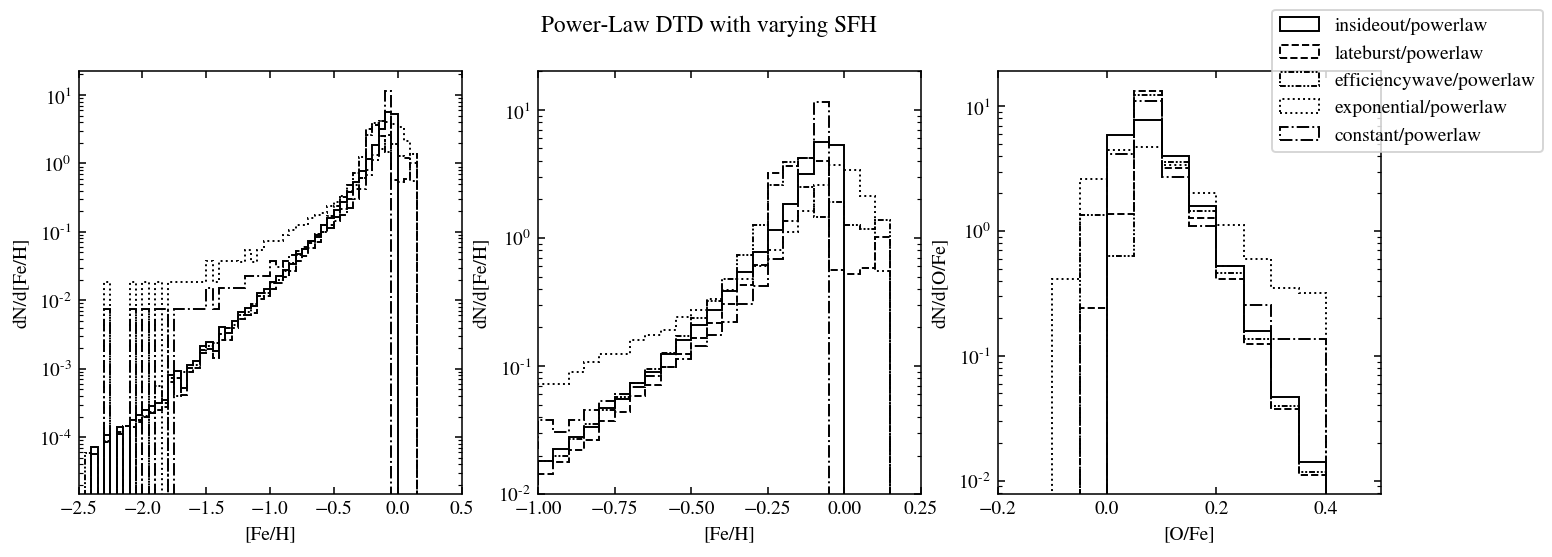

In [48]:
# MDFs
sfhs = ['insideout', 'lateburst', 'efficiencywave', 'exponential', 'constant']
dtd = 'powerlaw'
runs = [os.path.join(sfh, dtd) for sfh in sfhs]
plot_mdf(runs, title='Power-Law DTD with varying SFH', 
         legend_labels=['Inside-Out', 'Late-Burst', 'Exponential', 'Constant'])

This time, holding SFH constant and altering the Ia DTD. Overall the DTD has a relatively small effect on the MDF, with a much more noticeable impact on the ADF, especially at high alpha.

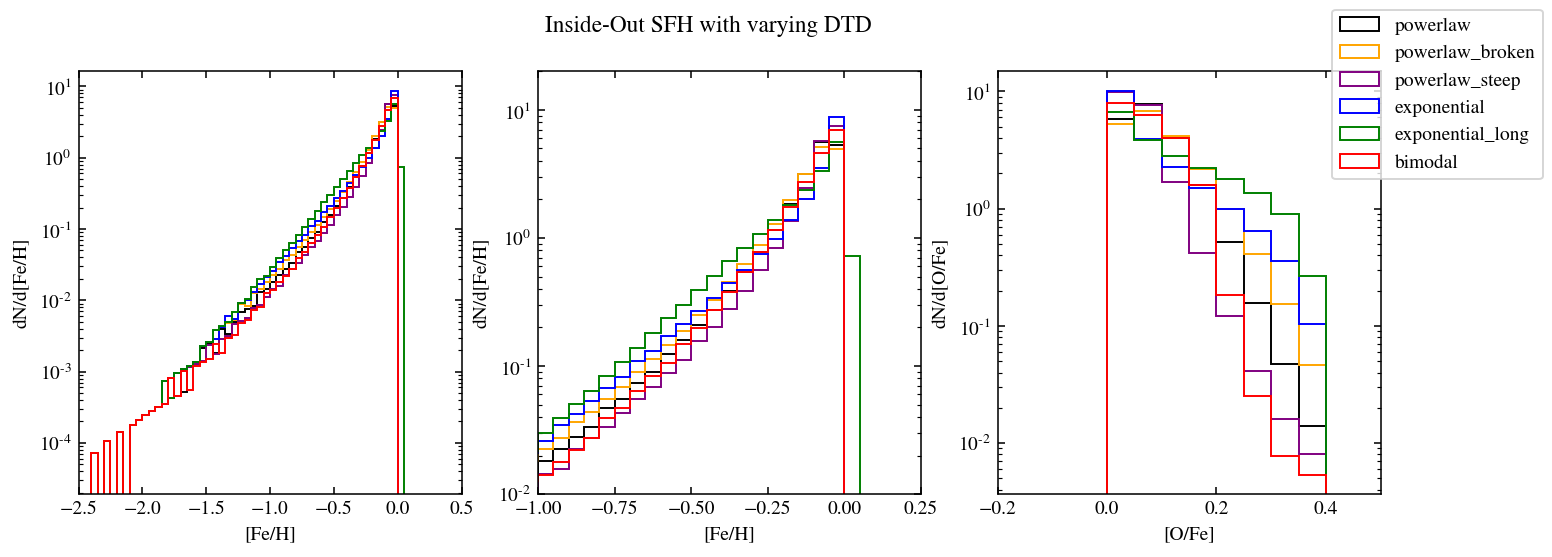

In [49]:
fig, axs = tri_mdf()
dtds = ['powerlaw', 'powerlaw_broken', 'powerlaw_steep', 'exponential', 'exponential_long', 'bimodal']
sfh = 'insideout'
ls = '-'
for dtd in dtds:
    mdf = vice.mdf(str(os.path.join('outputs', sfh, dtd)))
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    c = COLORS[dtd]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=dtd)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
fig.suptitle('Inside-Out SFH with varying DTD')
plt.show()

Same as above but linear scale. Here it's easier to see the changes to the peak of the distributions. There is a ~40% difference between the power-law and exponential DTDs at the peak of the MDF. Increasing the exponential timescale greatly decreases the peak value of the MDF. Differences in the high-alpha tail are still visible in linear scale, but once again there is a ~40% difference between the (short) exponential and power-law DTDs. The exponential ADF also has the steepest fall-off of any of them. Interestingly, the steep powerlaw and exponential DTDs produce the same number of [O/Fe] = 0.0 stars.

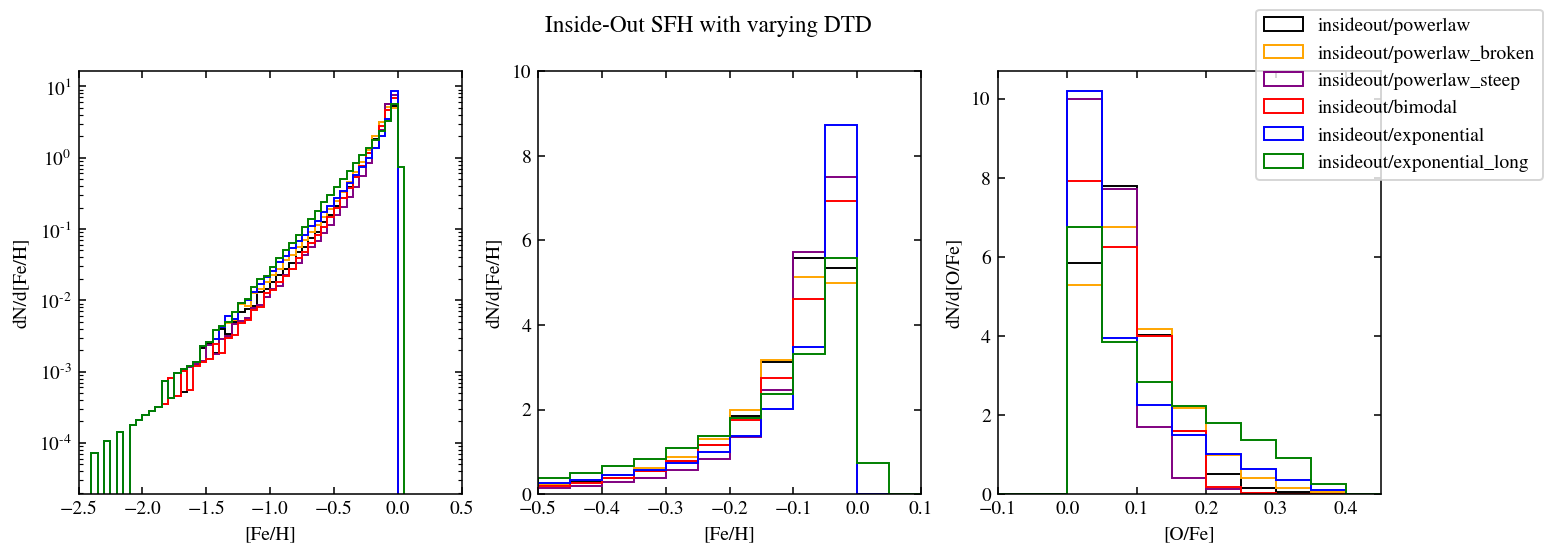

In [50]:
sfh = 'insideout'
dtds = ['powerlaw', 'powerlaw_broken', 'powerlaw_steep', 'bimodal', 'exponential', 'exponential_long']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD', logy=False, ylim2=(0, 10), felim2=(-0.5, 0.1), olim=(-0.1, 0.45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal', 'Exponential', 'Long Exponential'])

Now looking at varying the DTD in the Conroy+ 2022 SFE model.

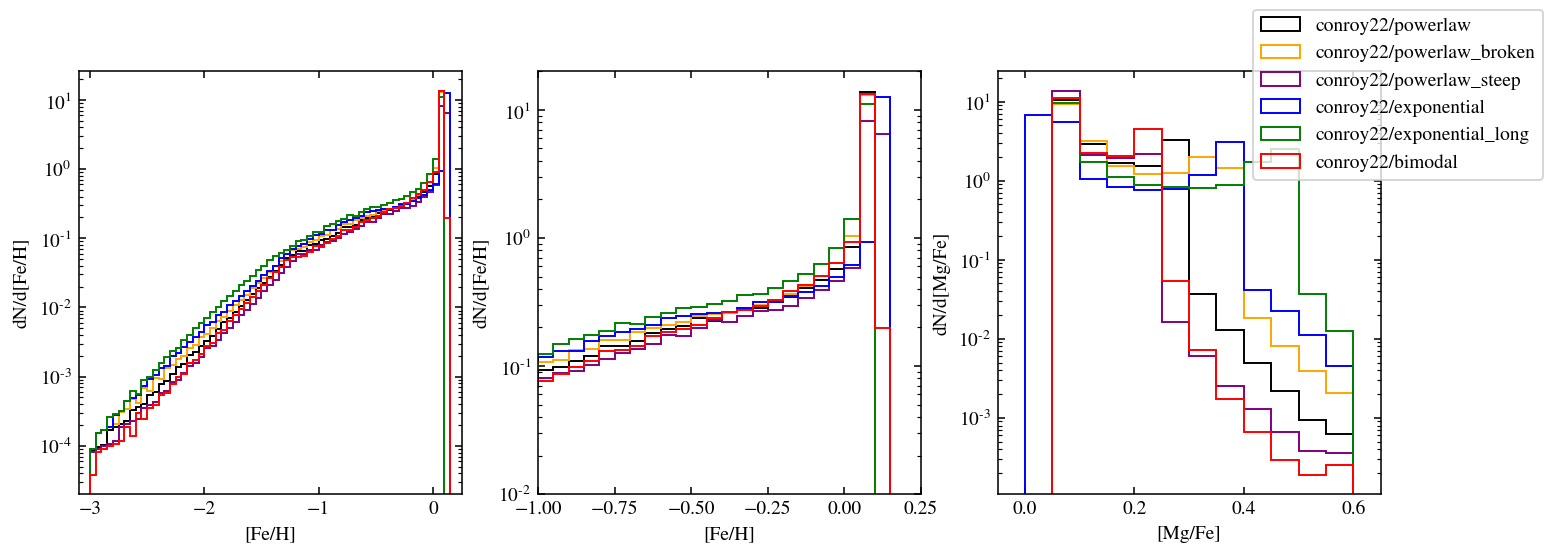

In [55]:
dtds = ['powerlaw', 'powerlaw_broken', 'powerlaw_steep', 'exponential', 'exponential_long', 'bimodal']
runs = ['conroy22/' + dtd for dtd in dtds]
plot_mdf(runs, alpha_tracer='Mg', felim1=(-3.1, 0.25), olim=(-0.05, 0.65))

Now a comparison between two of the more plausible SFHs and three representative DTDs. Changes in the MDF due to SFH outweigh any small difference in the peak of the distribution due to the DTD. Once again, the high-alpha tail is the easiest place to differentiate the DTDs, while things near the peak of the ADFs are a bit more muddled. The combination of SFE-driven burst and different DTDs affects where the low-end cutoff of the ADF lies. In general, the SFE-driven burst has a 0.05 dex higher *peak* to the ADF but also a much more significant low-alpha tail.

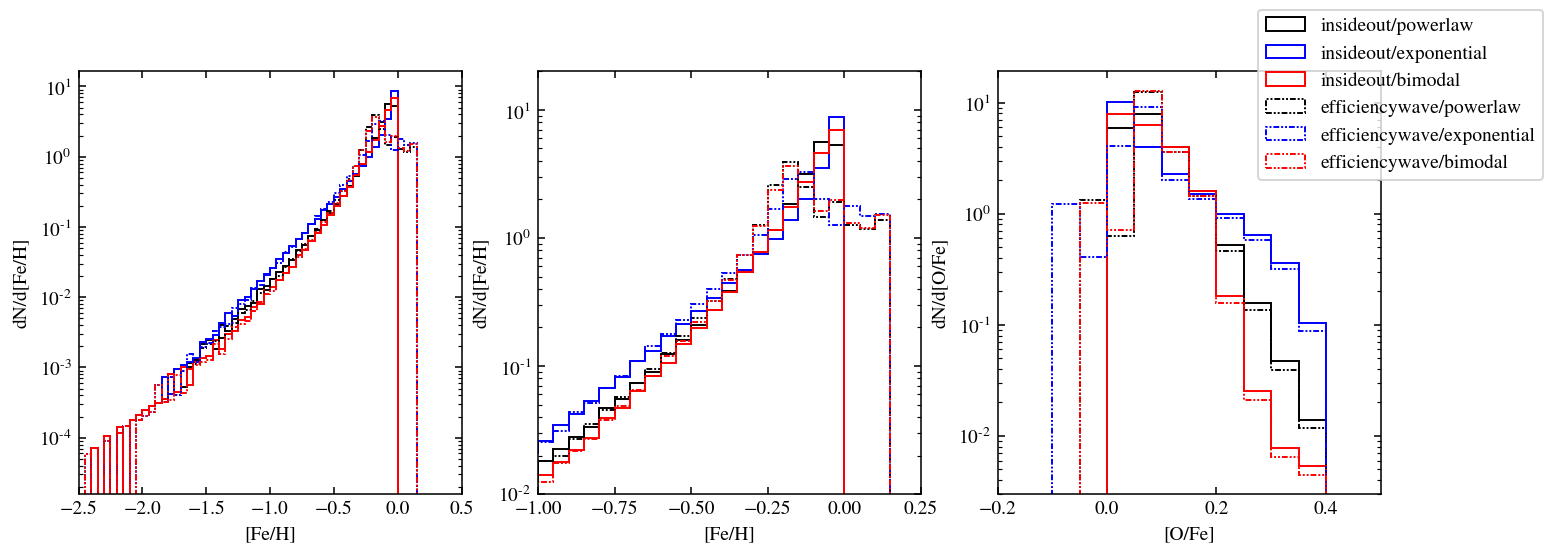

In [51]:
runs = ['insideout/powerlaw', 'insideout/exponential', 'insideout/bimodal', 'efficiencywave/powerlaw', 'efficiencywave/exponential', 'efficiencywave/bimodal']
plot_mdf(runs)

Now looking at exponential vs inside-out (similar to linear-exponential) SFHs, which are the most different at early times. Here the MDF peaks look more similar but the exponential SFH peak is ~0.1 dex higher. The exponential SFH also has shallower slope in the low-metallicity end of the MDF, with many more ultra-low-[Fe/H] stars. Meanwhile, both the SFH and DTD have a strong effect on the high-alpha end of the ADF. A higher fraction of high-alpha stars could either be due to a higher early-time SFR (lots of CC before the Ia kick in) or just a lower prompt fraction of SNe Ia. Once again, SFH has the biggest effect on the low-alpha end of the distribution. The exponentially declining SFR + exponential DTD actually produces the flattest MDF and ADF.

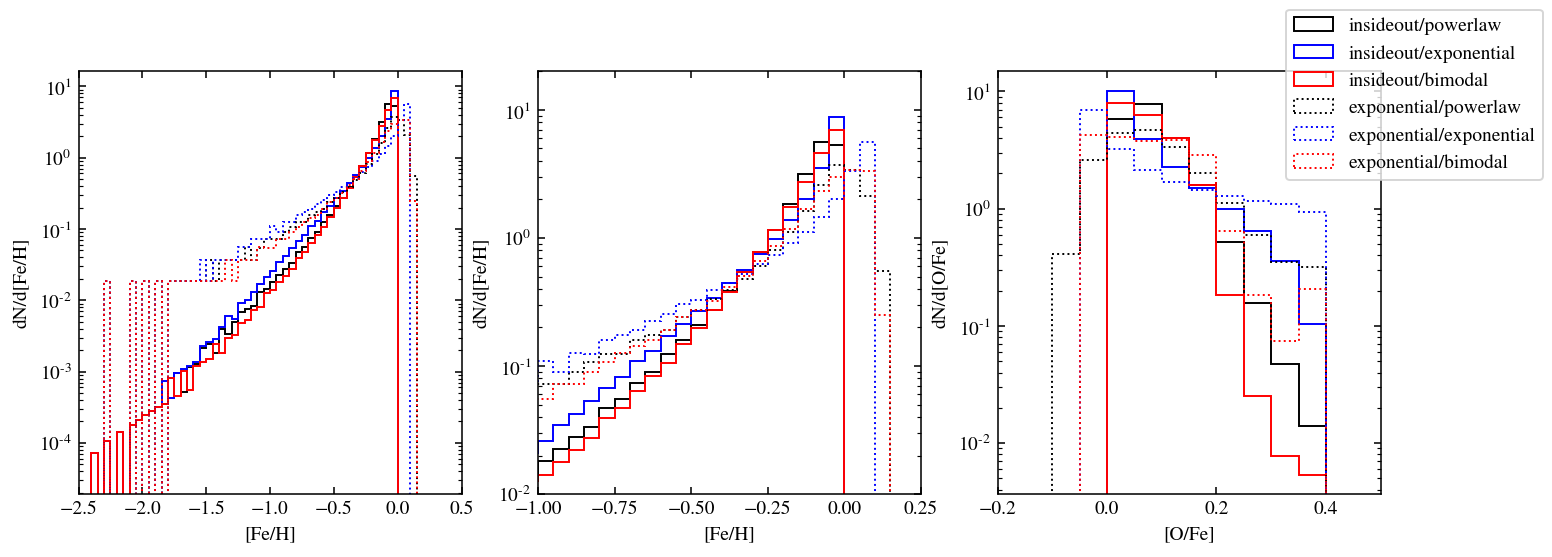

In [16]:
plot_mdf(['insideout/powerlaw', 'insideout/exponential', 'insideout/bimodal', 'exponential/powerlaw', 'exponential/exponential', 'exponential/bimodal'])

These runs span the full range of slopes to the ADF. A steep power-law DTD with the inside-out SFH has lots of early Type Ias and not much early star formation, so the result is heavily weighted toward solar metallicity and alpha stars. On the other hand, an exponential DTD with an exponentially declining SFH has not as many Type Ias and lots of early star formation, so the result has a lot of high-alpha, low-metallicity stars. In the middle are runs with a high early Ia rate *and* high early star formation, or the reverse. The insideout/exponential and exponential/powerlaw_steep ADFs look quite similar, notwithstanding the slight difference in the lower bound. They're a little more distinguishable in the MDF at the very low end or very high end.

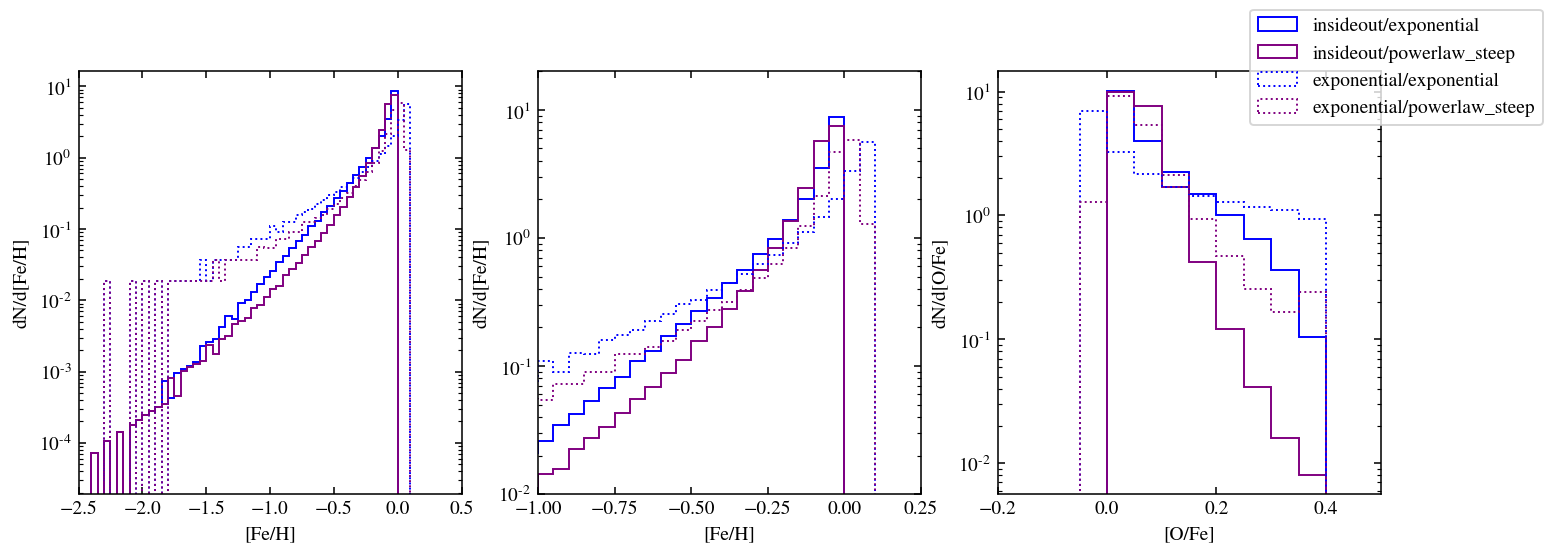

In [56]:
runs = ['insideout/exponential', 'insideout/powerlaw_steep', 'exponential/exponential', 'exponential/powerlaw_steep']
plot_mdf(runs)

Interestingly, inside-out vs constant SFH and exponential vs broken power-law all have quite similar MDFs and ADFs. The MDFs diverge at the very low end, but I'm not sure how much to trust the one-zone simulations there. The ADFs have slightly different shapes (exponential DTD is a bit more skewed to solar abundances) but similar high-alpha slopes.

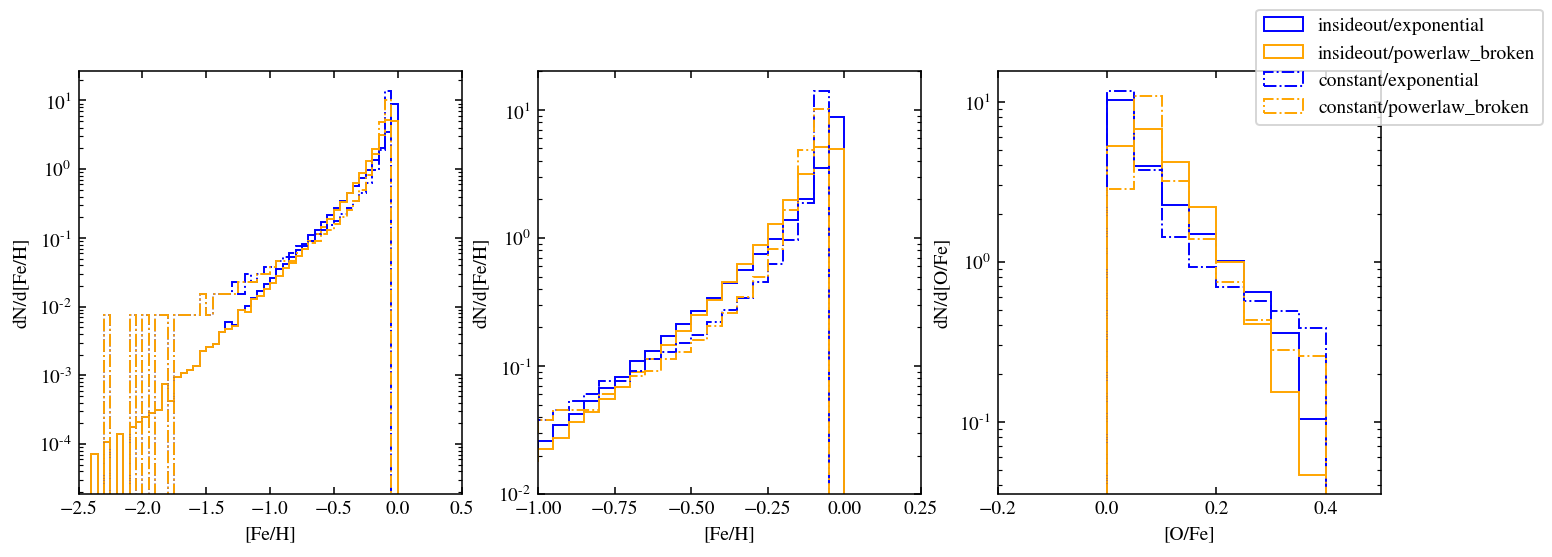

In [57]:
runs = ['insideout/exponential', 'insideout/powerlaw_broken', 'constant/exponential', 'constant/powerlaw_broken']
plot_mdf(runs)

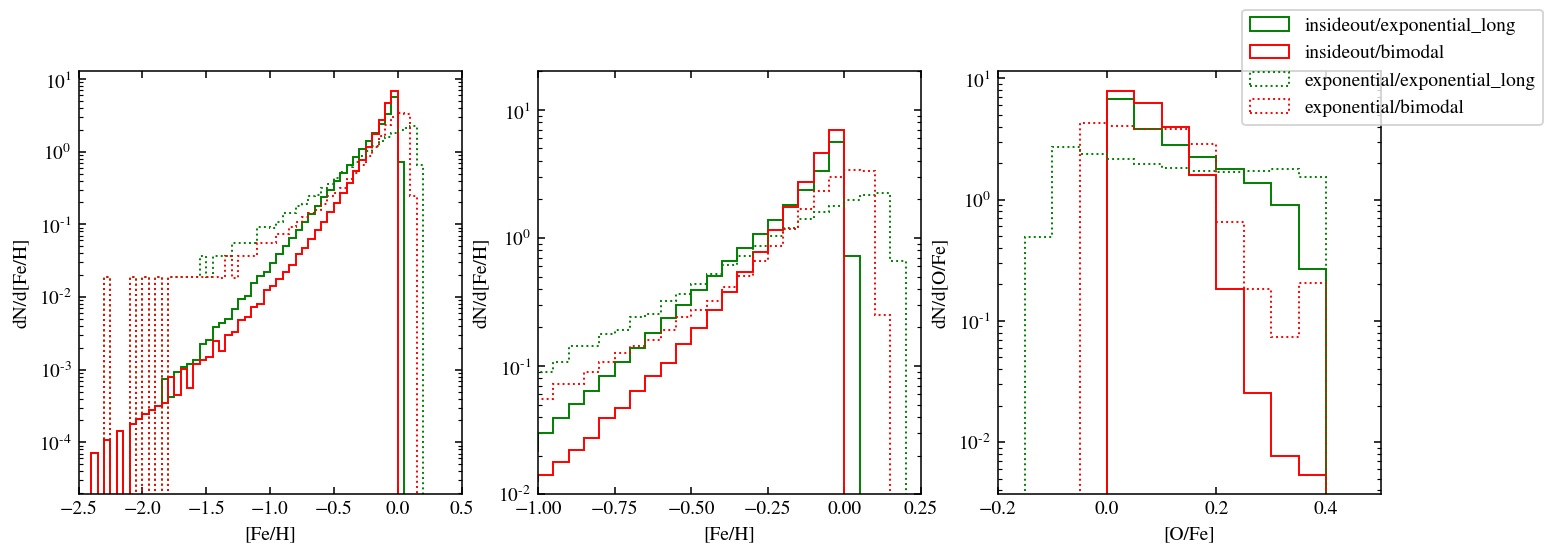

In [54]:
runs = ['insideout/exponential_long', 'insideout/bimodal', 'exponential/exponential_long', 'exponential/bimodal']
plot_mdf(runs)

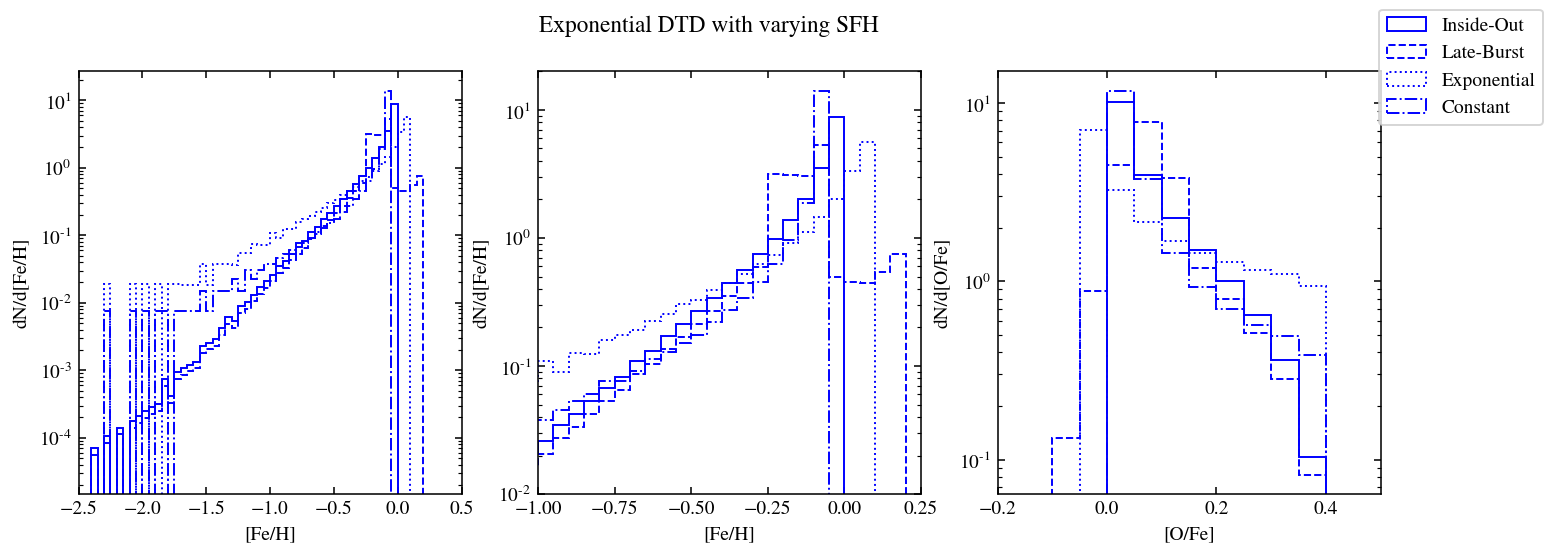

In [20]:
# MDFs
sfhs = ['insideout', 'lateburst', 'exponential', 'constant']
dtd = 'exponential'
runs = [os.path.join(sfh, dtd) for sfh in sfhs]
plot_mdf(runs, title='Exponential DTD with varying SFH', 
         legend_labels=['Inside-Out', 'Late-Burst', 'Exponential', 'Constant'])

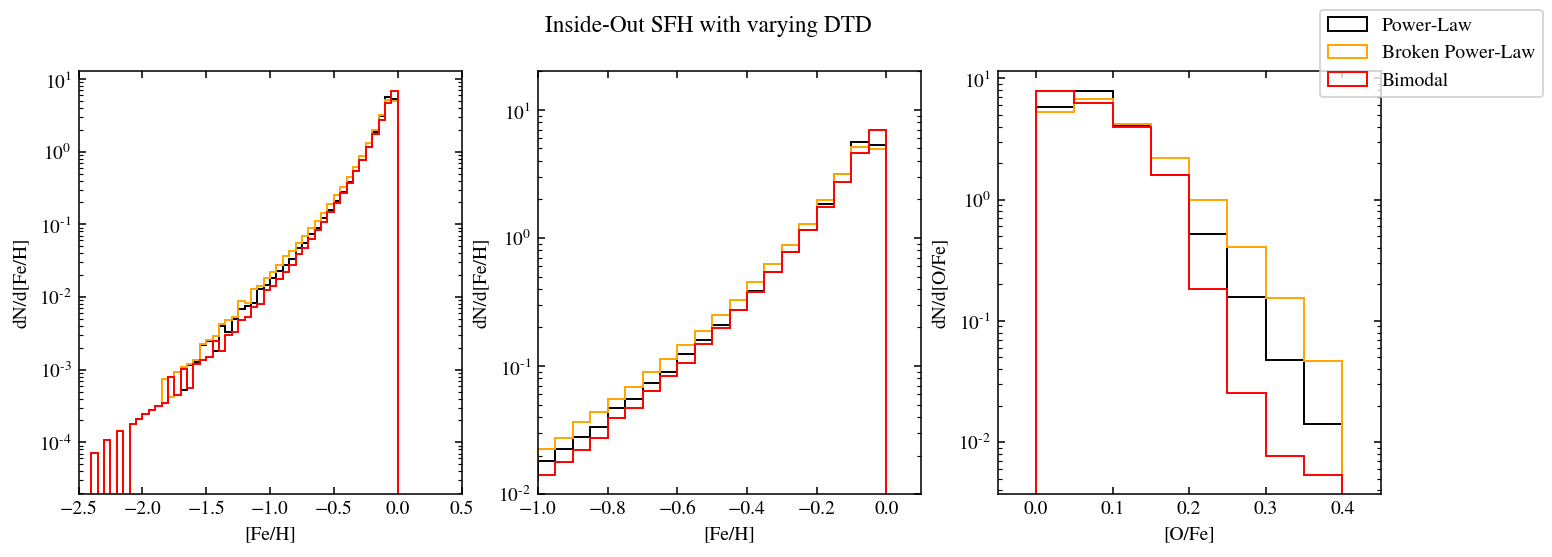

In [23]:
sfh = 'insideout'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD', felim2=(-1, 0.1), olim=(-.05, .45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

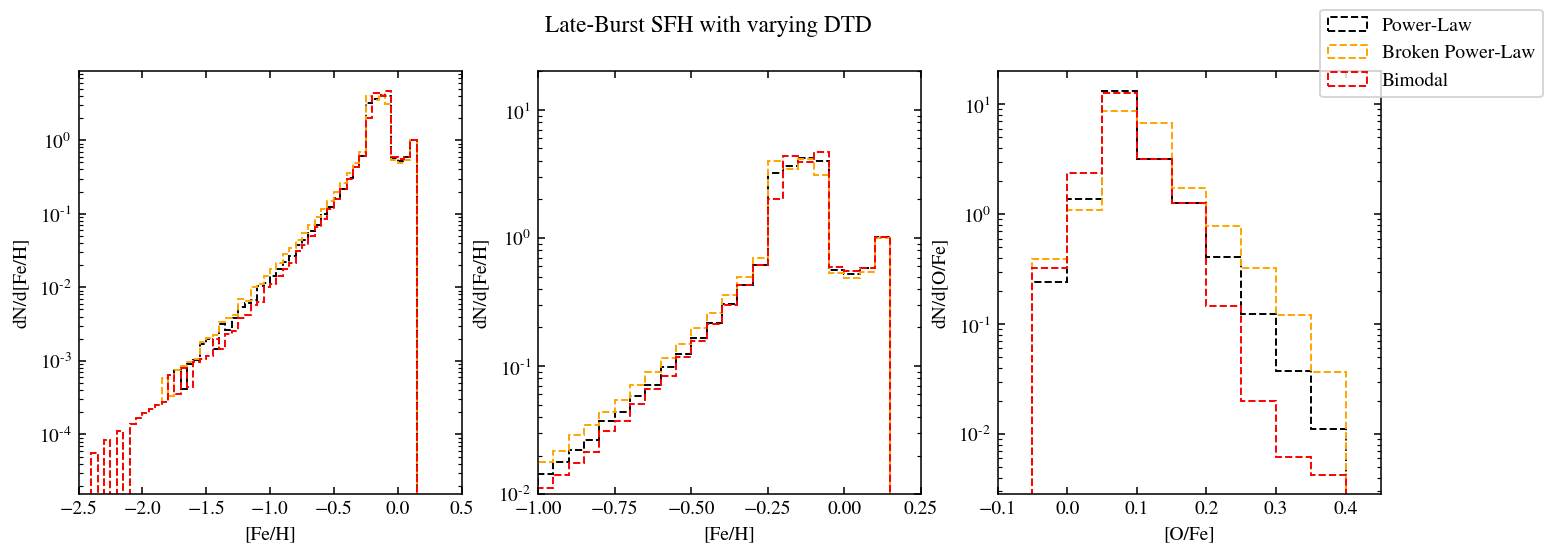

In [24]:
sfh = 'lateburst'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Late-Burst SFH with varying DTD', olim=(-0.1, 0.45),
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

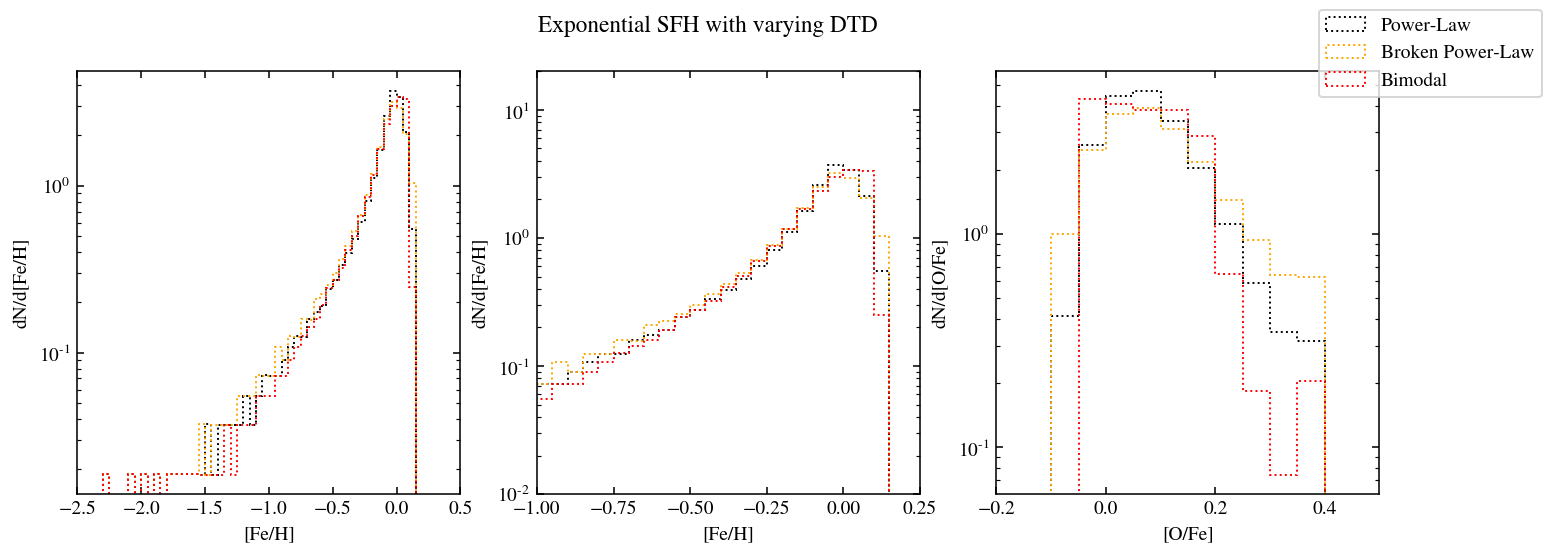

In [25]:
sfh = 'exponential'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Exponential SFH with varying DTD', 
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'])

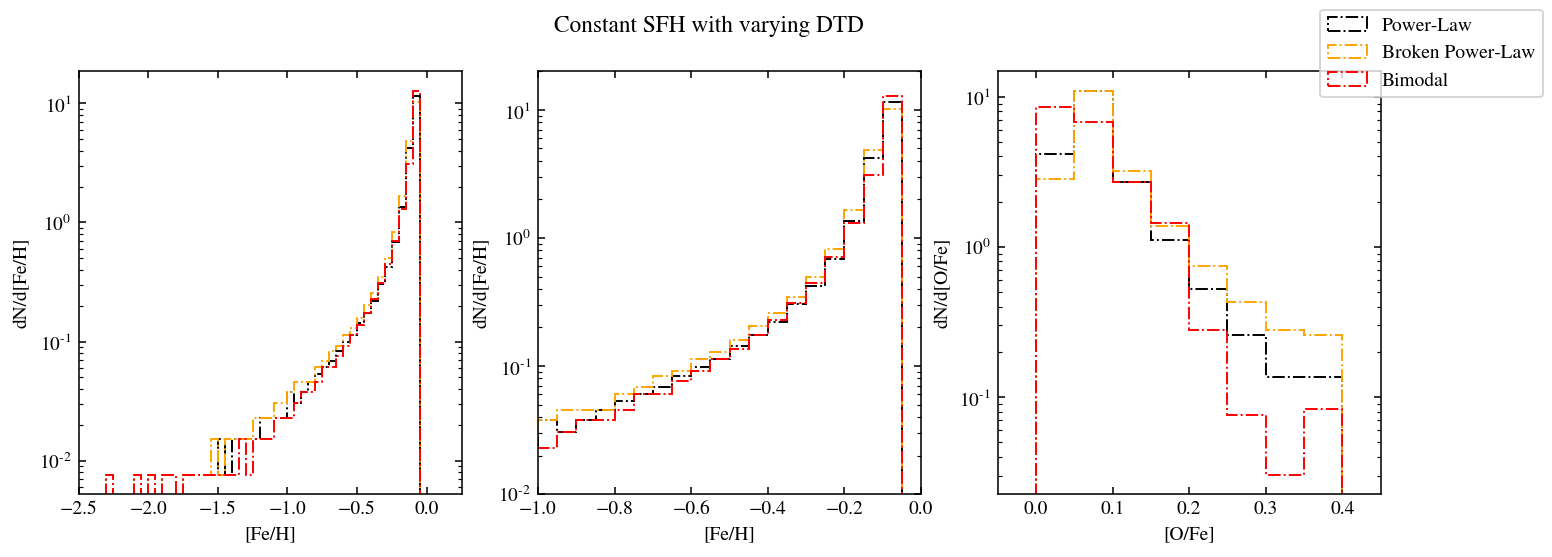

In [26]:
sfh = 'constant'
dtds = ['powerlaw', 'powerlaw_broken', 'bimodal']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Constant SFH with varying DTD', 
         legend_labels=['Power-Law', 'Broken Power-Law', 'Bimodal'],
         olim=(-.05, .45), felim1=(-2.5, 0.25), felim2=(-1,0))

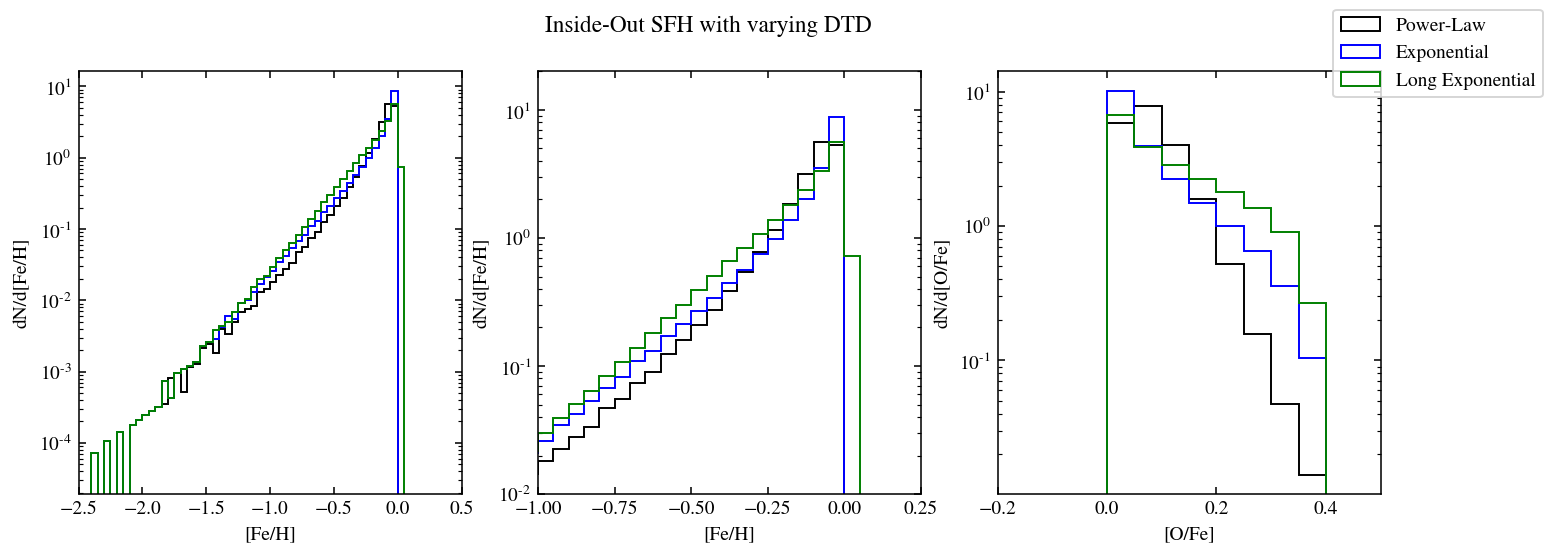

In [27]:
sfh = 'insideout'
dtds = ['powerlaw', 'exponential', 'exponential_long']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Inside-Out SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Long Exponential'])

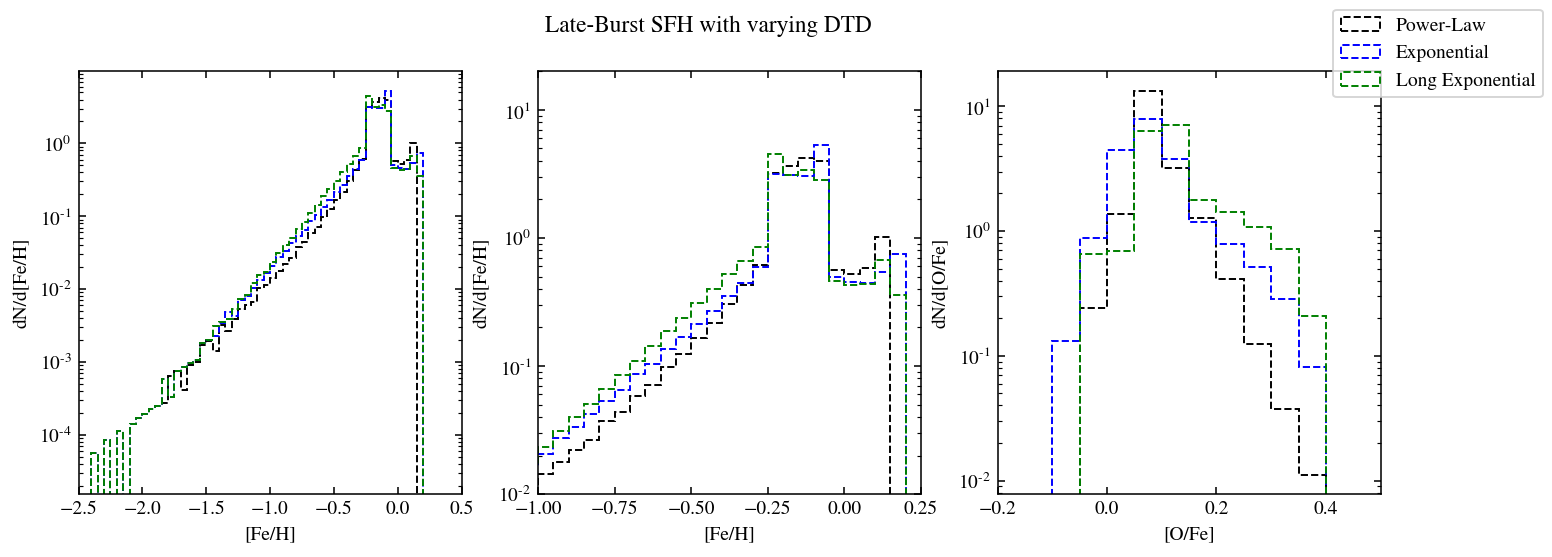

In [28]:
sfh = 'lateburst'
dtds = ['powerlaw', 'exponential', 'exponential_long']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Late-Burst SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Long Exponential'])

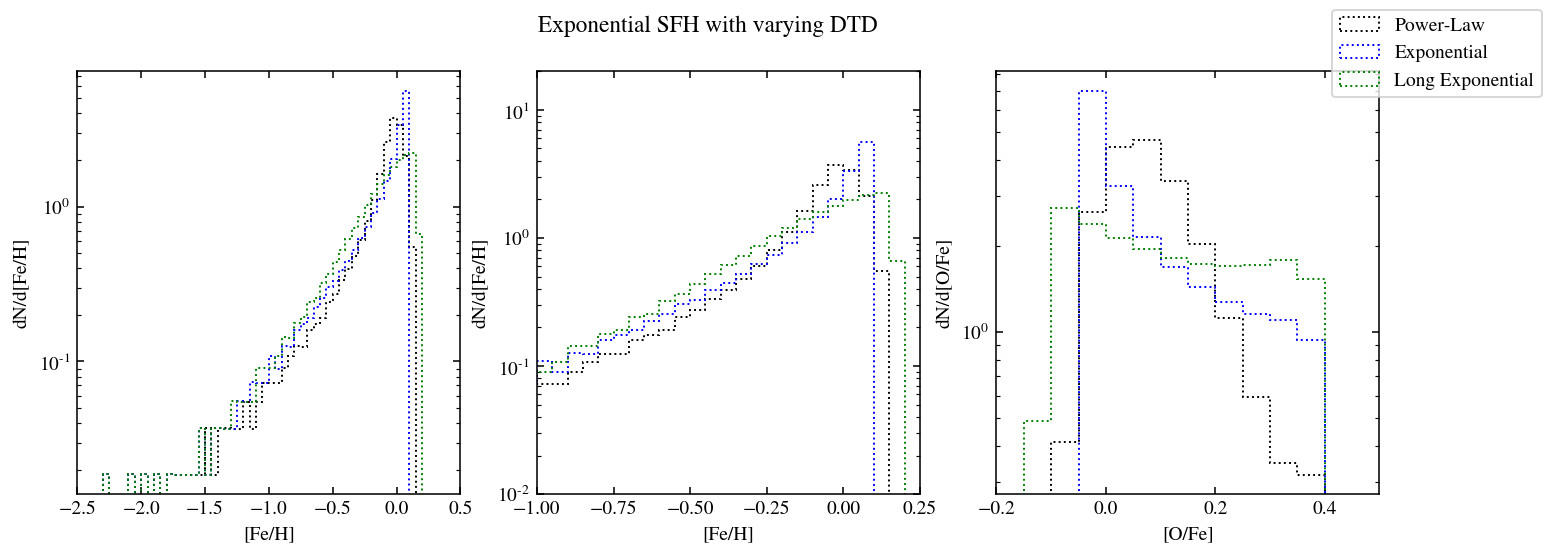

In [29]:
sfh = 'exponential'
dtds = ['powerlaw', 'exponential', 'exponential_long']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Exponential SFH with varying DTD',
         legend_labels=['Power-Law', 'Exponential', 'Long Exponential'])

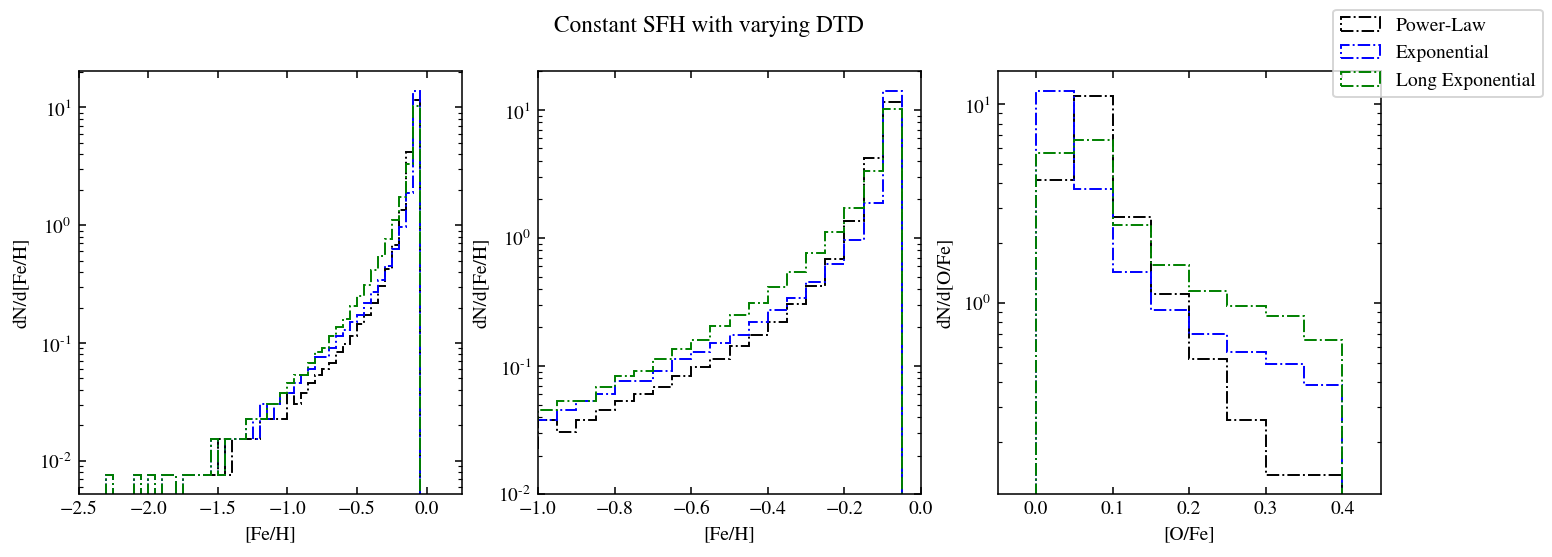

In [30]:
sfh = 'constant'
dtds = ['powerlaw', 'exponential', 'exponential_long']
runs = [os.path.join(sfh, dtd) for dtd in dtds]
plot_mdf(runs, title='Constant SFH with varying DTD', felim1=(-2.5, 0.25), felim2=(-1, 0), olim=(-0.05, 0.45),
         legend_labels=['Power-Law', 'Exponential', 'Long Exponential'])

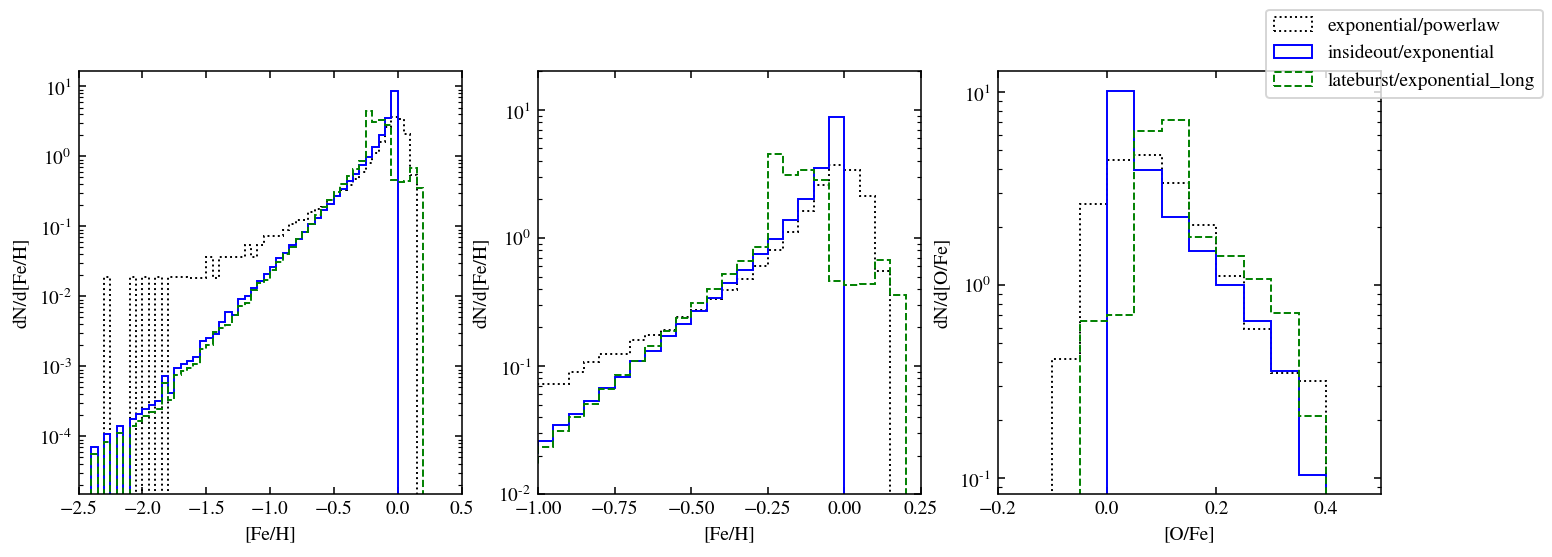

In [31]:
fig, axs = tri_mdf()
runs = ['exponential/powerlaw', 'insideout/exponential', 'lateburst/exponential_long']
for run in runs:
    mdf = vice.mdf('outputs/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

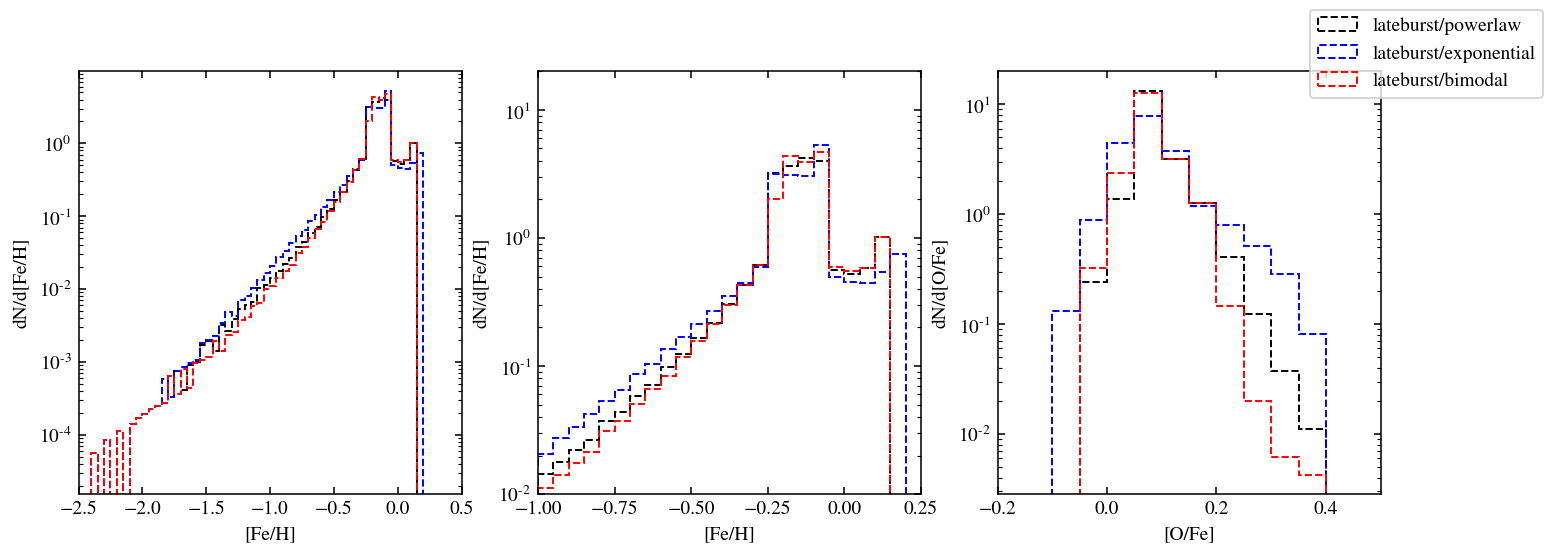

In [32]:
fig, axs = tri_mdf()
runs = ['lateburst/powerlaw', 'lateburst/exponential', 'lateburst/bimodal']
for run in runs:
    mdf = vice.mdf('outputs/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

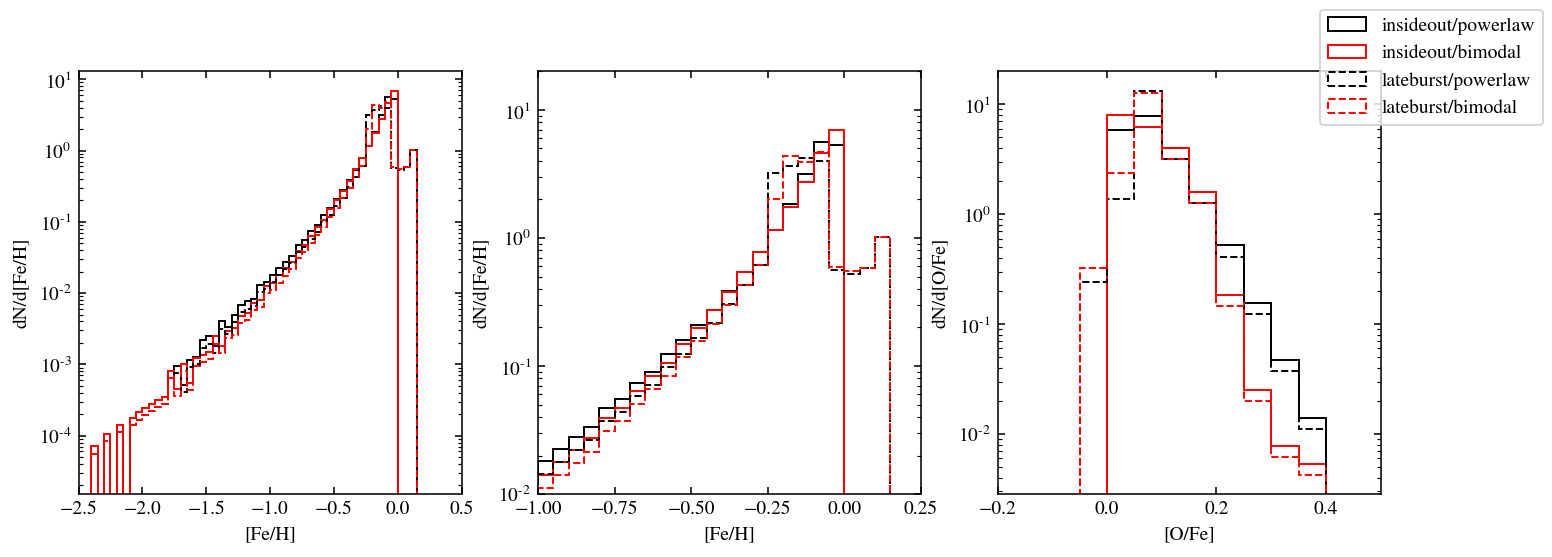

In [33]:
fig, axs = tri_mdf()
runs = ['insideout/powerlaw', 'insideout/bimodal', 'lateburst/powerlaw', 'lateburst/bimodal']
for run in runs:
    mdf = vice.mdf('outputs/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

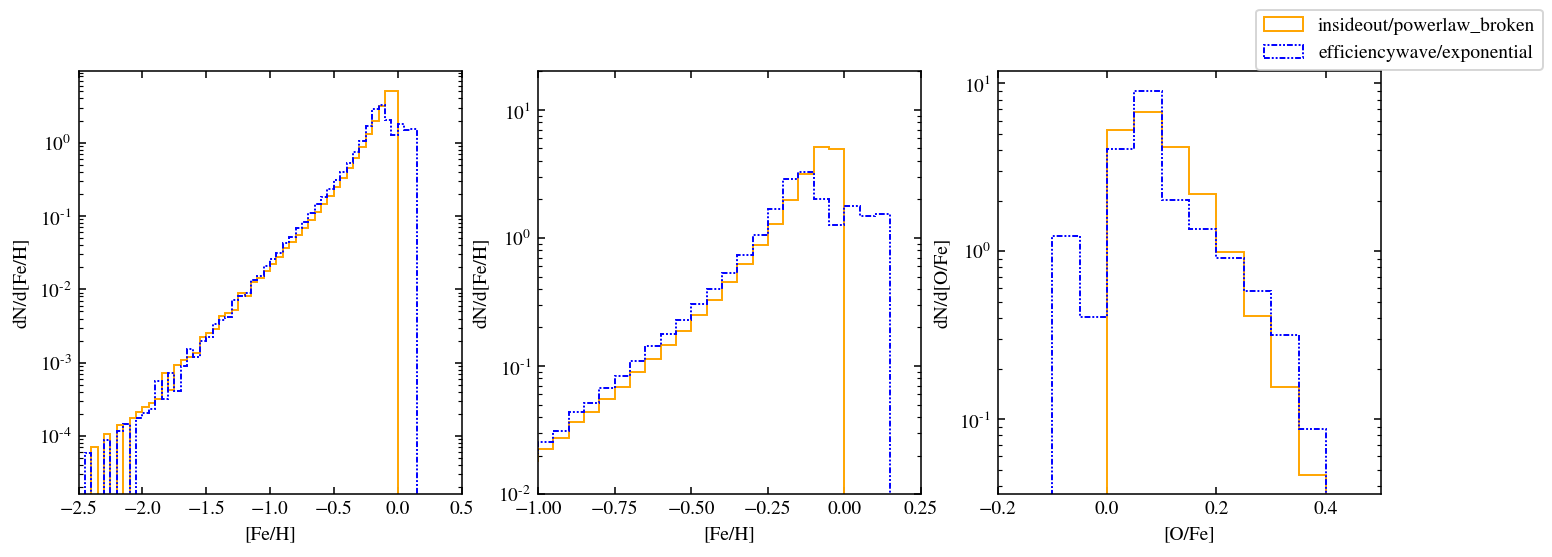

In [61]:
fig, axs = tri_mdf()
runs = ['insideout/powerlaw_broken', 'efficiencywave/exponential']
for run in runs:
    mdf = vice.mdf('outputs/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

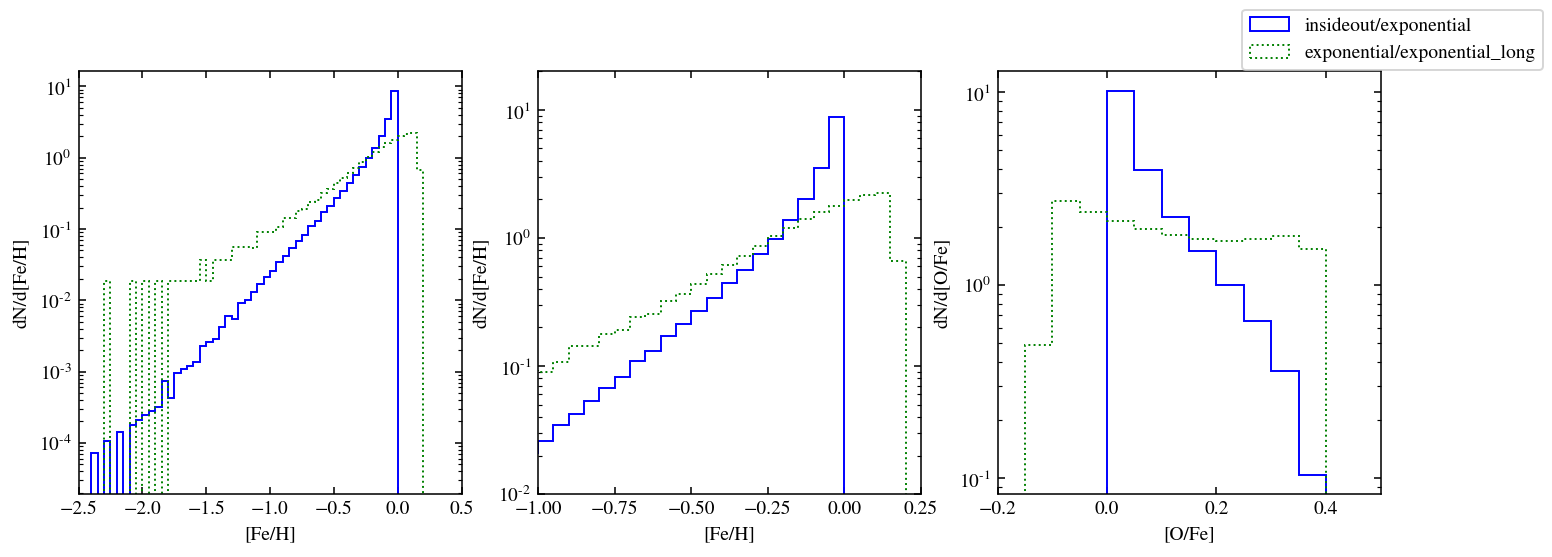

In [35]:
fig, axs = tri_mdf()
runs = ['insideout/exponential', 'exponential/exponential_long']
for run in runs:
    mdf = vice.mdf('outputs/' + run)
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    sfh = run.split('/')[0]
    dtd = run.split('/')[1]
    c = COLORS[dtd]
    ls = LINESTYLES[sfh]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=run)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[o/fe]'], histtype='step', color=c, linestyle=ls)

fig.legend()
plt.show()

## Old stuff

In [36]:
# Power-law DTD with shorter 40 Myr delay time
sz = vice.singlezone(name='sz_short', elements=('o', 'fe'), RIa='plaw', delay=0.04)
sz.run(simtime)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/singlezone/singlezone.py:1778: UserWarning: Specified output times denser are finer than the timestep size. This may affect when output is written. Consider rerunning this simulation with coarser output times.
  return self.__c_version.run(output_times, capture = capture,


In [37]:
# Exponential DTDs
# Medium timescale
sz = vice.singlezone(name='sz_exp', elements=('o', 'fe'), RIa='exp', tau_ia=1.5)
sz.run(simtime)
# Short timescale
sz = vice.singlezone(name='sz_sexp', elements=('o', 'fe'), RIa='exp', tau_ia=0.5)
sz.run(simtime)
# Long timescale
sz = vice.singlezone(name='sz_lexp', elements=('o', 'fe'), RIa='exp', tau_ia=5.5)
sz.run(simtime)

In [38]:
# Wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

sz = vice.singlezone(name='sz_wgauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=2, center=3))
sz.run(simtime)

In [39]:
# Narrow gaussian DTD
sz = vice.singlezone(name='sz_ngauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=0.2, center=1))
sz.run(simtime)

In [40]:
# Bimodal DTD
def bimodal(t, tau_ia=0.09):
    if t < tau_ia:
        return 10**(1.4 - 50*(np.log10(t*1e9) - 7.7)**2)
    else:
        return 10**(-0.8 - 0.9*(np.log10(t*1e9) - 8.7)**2)
    
sz = vice.singlezone(name='sz_bi', elements=('o', 'fe'), RIa=bimodal, delay=0.04)
sz.run(simtime)

In [41]:
# Uniform DTD
def uniform(t, tmin=0, tmax=1):
    if t >= tmin and t < tmax:
        return 1
    else:
        return 0

sz = vice.singlezone(name='sz_uni', elements=('o', 'fe'), RIa=uniform)
sz.run(simtime)

Plot Fe vs time, alpha vs time, and alpha vs Fe.

In [42]:
sz = vice.singlezone(name='sz_long_sfe', elements=('o', 'fe'), tau_star=5)
sz.run(simtime)

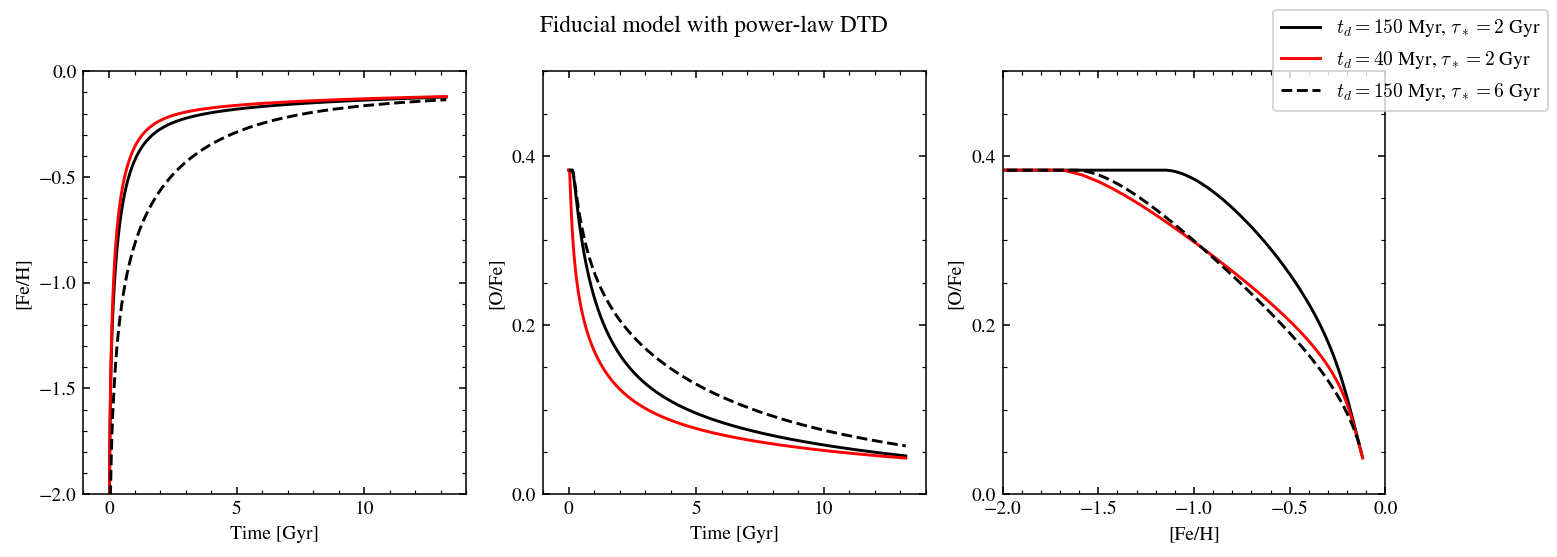

In [43]:
# Altering minimum delay time vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-2, 0), olim=(0, 0.5))
                                         
# 150 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=2$ Gyr'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 40 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.04, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=40$ Myr, $\tau_*=2$ Gyr'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 150 Myr delay with 5 Gyr SFE timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=6)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=6$ Gyr'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with power-law DTD')
fig.legend()
plt.show()

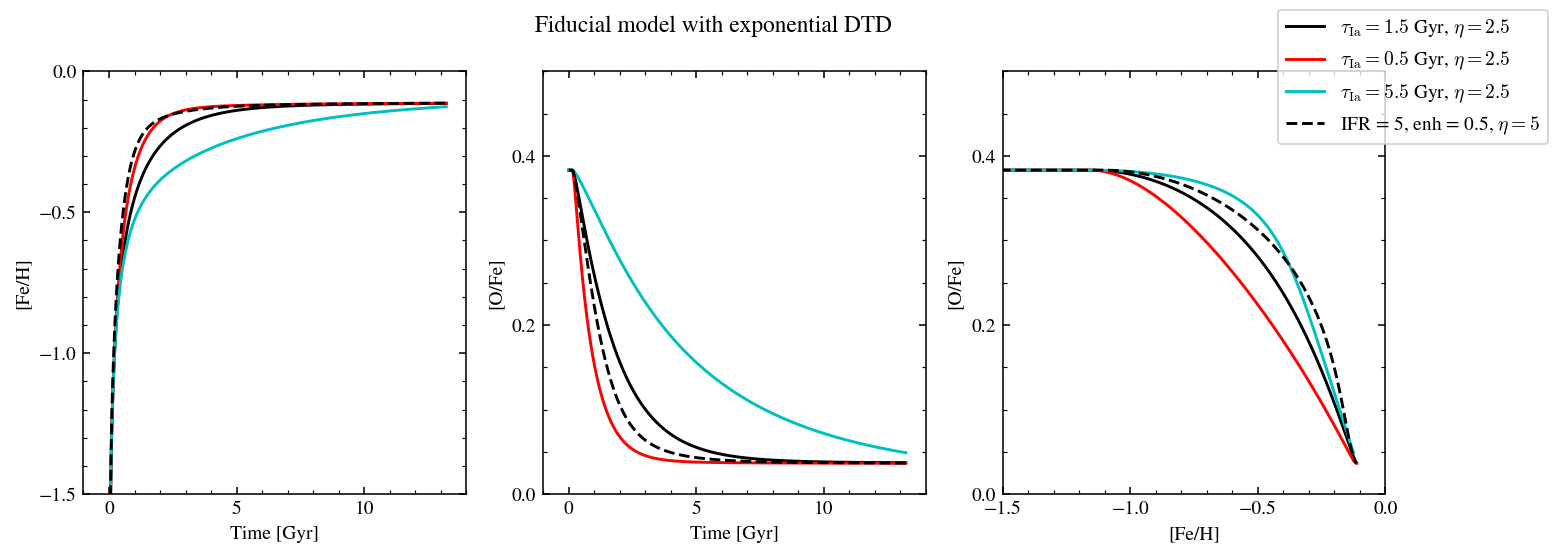

In [44]:
# Altering exponential Ia timescale vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-1.5, 0), olim=(0, 0.5))
                                         
# Fiducial Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=1.5$ Gyr, $\eta=2.5$'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Shorter Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=0.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=0.5$ Gyr, $\eta=2.5$'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Longer Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=5.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=5.5$ Gyr, $\eta=2.5$'
style = 'c'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Other parameter changes
# need to set Mg0
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, mode='ifr', func=lambda t: 5, enhancement=0.5, eta=5)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = 'IFR = 5, enh = 0.5, $\eta=5$'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with exponential DTD')
fig.legend()
plt.show()